# TDT4173 Machine Learning project

### Kaggle Team Name: Model Seducing Maestros [65]

### Full names: 
- Thomas Storvik: 506714
- Kaja Erfjord: 529196



In [85]:
import re
import itertools
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *
from sklearn.linear_model import LinearRegression

In [86]:
# Setting the maximum number of rows when you printing out a DataFrame
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

### Exploratory data analysis

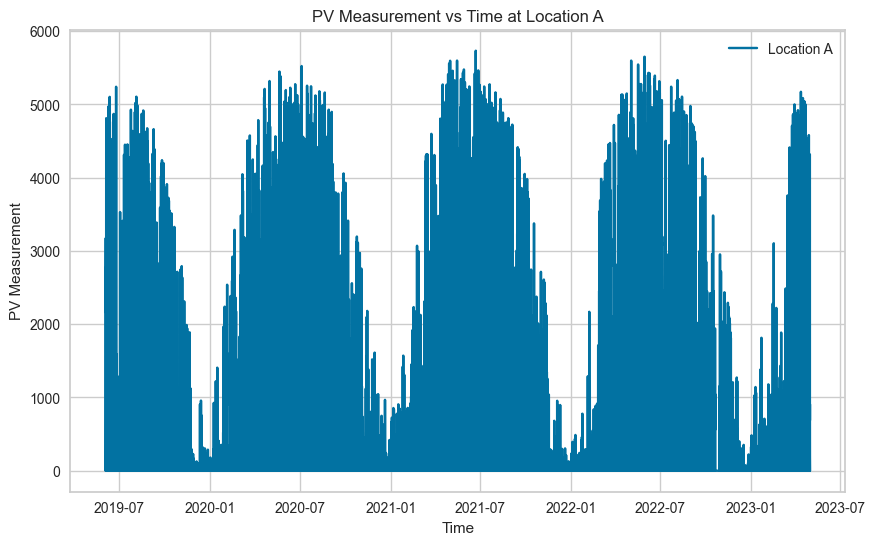

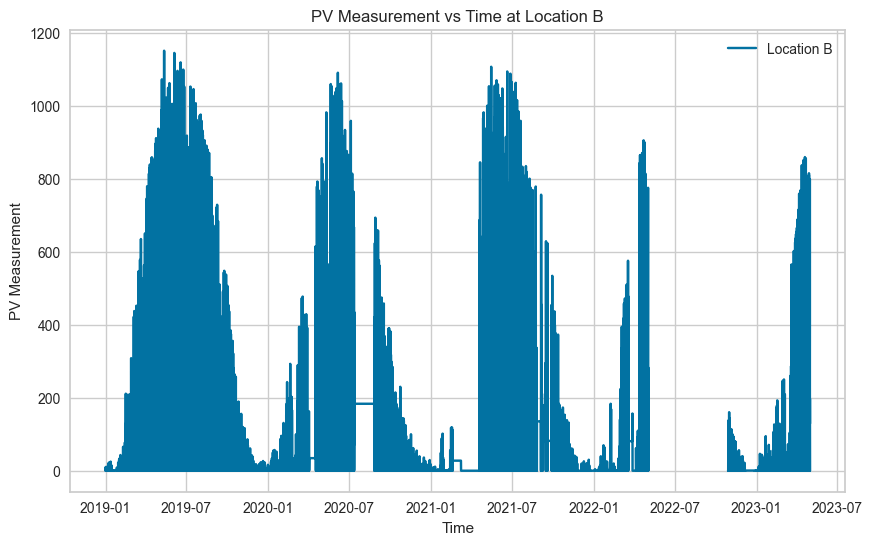

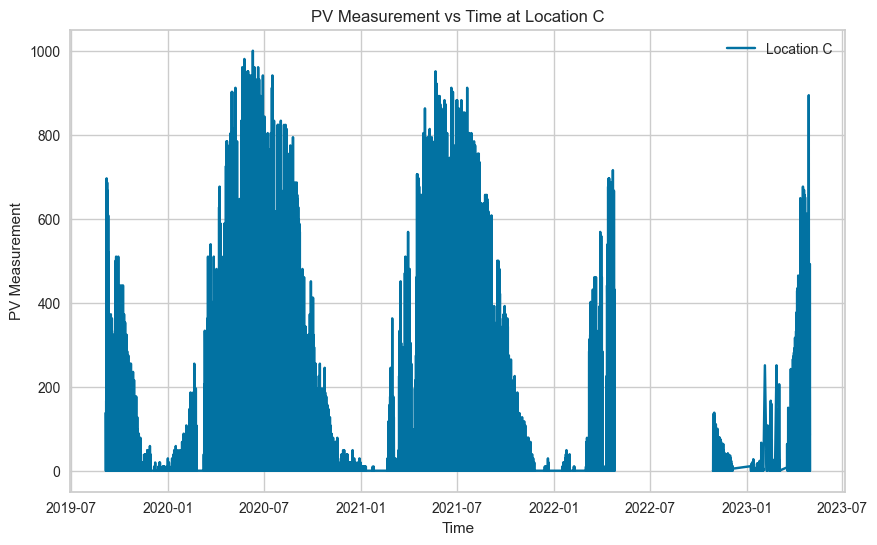

In [87]:
locations = [ 'A', 'B', 'C']
for loc in locations: 
    train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    plt.figure(figsize=(10, 6))
    plt.plot(train['time'], train['pv_measurement'], label=f'Location {loc}')

    # Set labels and title
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title(f'PV Measurement vs Time at Location {loc}')
    plt.legend()
    plt.show()

As we can see from the plots mostly in location B and C the poweroutput is saturated over a long periode instead of fluctuation. This is not natural, so we remove this periodes from out training data so only the intuitve data is remaining.

In [88]:
locations = [ 'A', 'B', 'C']
for loc in locations:

    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet')
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    date_calc_resampled_ob = X_train_estimated.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    observed_resampled = X_train_estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = X_train_observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    merged_data = pd.merge(X_train_estimated, X_train_observed, left_index=True, right_index=True)
    
    # Merge with target data
    df = pd.concat([observed_resampled, observed_resampled], axis=0).sort_values(by='date_forecast')
    merged_data = pd.merge(train, df, how='inner', left_on='time', right_on='date_forecast')

    # Filter where is_day is 0 and calculate mean pv_measurement
    mean_pv_measurement = merged_data[merged_data['is_day:idx'] == 0]['pv_measurement'].mean()

    print(f"Location {loc} - Mean PV Measurement when is_day is 0: {mean_pv_measurement}")

Location A - Mean PV Measurement when is_day is 0: 0.0937545922116091
Location B - Mean PV Measurement when is_day is 0: 0.1319828965216726
Location C - Mean PV Measurement when is_day is 0: 0.324719904648391


As we can see the mean value for pv_measurement when is_day is zero is really close to zero. We want to only train on data where the pv measurment is not zero as training on data where the targets is zero is just extra noise. As the is_say feature almost prefectly capture the hours each day where we have zero power output we are removing all rows in training data where pv_measurement is zero and after prediction on the test set we multiply the is_day feature with the predictions as it will set all predictions at night to zero. As this is not perfect we are also setting all predictions under a treshold to zero, this treshold has been found by trial and error.

### Time features

First, we made 3 sets of time features to get models that capture diffrent important aspects from the data

In [89]:
# Time features nr 1
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  

    # Extract various time features
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    df['year'] = df[time_column].dt.year
    #df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/24.)
    #df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)
    #pd.set_option('display.max_rows', None)
    #df = df.drop(['hour'])
    #print(df['sin_hour'])
    
    return df

In [90]:
# Time features nr 2
def add_time_features_cat(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  
    
    df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/23.)
    df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)
    
    return df

In [91]:
# Time features nr 3
def add_time_features_cat_2(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column]) 

    df['day_of_week'] = df[time_column].dt.dayofweek
    df['sin_hour'] = np.sin(2*np.pi * df[time_column].dt.hour/23.)
    df['sin_month'] = np.sin(2*np.pi * df[time_column].dt.month/12.)
    df['cos_hour'] = np.cos(2*np.pi * df[time_column].dt.hour/23.)
    df['cos_month'] = np.cos(2*np.pi * df[time_column].dt.month/12.)

    return df

In [92]:
'''#Here we are calculating the lineral correlation of each feature to the power output
# Now, calculate the correlation matrix
correlation_matrix_a = merged_data_a.corr()

# You might want to focus on the correlations with the target variable
correlations_with_target_a = correlation_matrix_a['pv_measurement'].sort_values(ascending=False)
#print(correlations_with_target_a)

# Now, calculate the correlation matrix
correlation_matrix_b = merged_data_b.corr()

# You might want to focus on the correlations with the target variable
correlations_with_target_b = correlation_matrix_b['pv_measurement'].sort_values(ascending=False)
#print(correlations_with_target_b)

# Now, calculate the correlation matrix
correlation_matrix_c = merged_data_c.corr()

# You might want to focus on the correlations with the target variable
correlations_with_target_c = correlation_matrix_c['pv_measurement'].sort_values(ascending=False)
#print(correlations_with_target_c)


# Create a DataFrame to hold the correlation values
correlation_comparison = pd.DataFrame({
    'Feature': correlations_with_target_a.index,
    'Location_A': correlations_with_target_a.values,
    'Location_B': correlations_with_target_b.reindex(correlations_with_target_a.index).values,
    'Location_C': correlations_with_target_c.reindex(correlations_with_target_a.index).values
})

# Calculate the absolute difference in correlation values across locations
correlation_comparison['Max_Diff'] = correlation_comparison.apply(
    lambda row: max(row['Location_A'], row['Location_B'], row['Location_C']) - 
                min(row['Location_A'], row['Location_B'], row['Location_C']), axis=1)


# Sort the DataFrame based on the difference in correlation values
correlation_comparison = correlation_comparison.sort_values(by='Max_Diff', ascending=False)
# Print the DataFrame
print(correlation_comparison)
'''

"#Here we are calculating the lineral correlation of each feature to the power output\n# Now, calculate the correlation matrix\ncorrelation_matrix_a = merged_data_a.corr()\n\n# You might want to focus on the correlations with the target variable\ncorrelations_with_target_a = correlation_matrix_a['pv_measurement'].sort_values(ascending=False)\n#print(correlations_with_target_a)\n\n# Now, calculate the correlation matrix\ncorrelation_matrix_b = merged_data_b.corr()\n\n# You might want to focus on the correlations with the target variable\ncorrelations_with_target_b = correlation_matrix_b['pv_measurement'].sort_values(ascending=False)\n#print(correlations_with_target_b)\n\n# Now, calculate the correlation matrix\ncorrelation_matrix_c = merged_data_c.corr()\n\n# You might want to focus on the correlations with the target variable\ncorrelations_with_target_c = correlation_matrix_c['pv_measurement'].sort_values(ascending=False)\n#print(correlations_with_target_c)\n\n\n# Create a DataFrame to

### Plotting the target data
We added a fuction to plot the target data. Then we quickly realized that for some periodes the target value was saturated over a long duration. This dosent make sense as the poweroutput for solar panels should be fluctuating with the weather data, so we removed this part of the data. 

In [93]:
# Plotting the target data
def plot_targets(targets, start_date, end_date):
    
    # Slice the dataframe based on the provided start and end dates
    targets_subset = targets[(targets['time'] >= start_date) & (targets['time'] <= end_date)]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(targets_subset['time'], targets_subset['pv_measurement'], label='PV Measurement', color='blue')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Preprocessing
### Preprocessing for LightGBM and catboost
This first function is one of several preprocessing functions where we remove some features, remove noise and add some extra features

In [94]:
# Preprocessing LigtGBM + catboost
def preprocessing(targets, observed, estimated, test):
    
    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

# Extract hour and group by it to get the index of maximum value in each group, didnt work so commented out
    '''idx = targets.groupby([targets['time'].dt.date, targets['time'].dt.hour])['pv_measurement'].idxmax()
# Use the indices to get the corresponding rows from the original dataframe
    targets_max = targets.loc[idx].reset_index(drop=True)
    targets_mean = targets.set_index('time').resample('1H').mean().dropna(how='all').reset_index()
    pd.set_option('display.max_rows', None)'''

#Tried resampling for 30 min instead of an hour, but the idea didnt work, so commented out
    '''def process_data(df):
      # Shift date by 30 minutes
      df['date_forecast'] = df['date_forecast'] + pd.Timedelta(minutes=30)
      
      # Resample to 1H frequency
      resampled = df.set_index('date_forecast').resample('1H').mean().reset_index()
      
      # Drop the last row if it's the last half hour of data
      
      resampled = resampled.iloc[:-1]
      
      return resampled
    pd.set_option('display.max_rows', None)

    
    print(estimated)
    observed_resampled = process_data(observed)
    estimated_resampled = process_data(estimated)
    test_resampled = process_data(test)'''
    
    # Start the resampling from 15min to 1 hour
    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)
    
    #Save the is_day feature as this says a lot about when the power output is zero or not
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    #Drop some features that is noise
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = observed_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    
    # Printing the results
    print(f"The dataset starts from {first_date} and ends at {last_date}")

    start_date = '2017-07-01'  
    end_date = '2024-08-30'  

    # Make some extra date features that capture the diffrence in obsverved and estimated data
    def process_data(observed, estimated, test):
    
    # 1. Create time-delta for estimated data
      estimated['time_dummy'] = (estimated['date_forecast'] - estimated['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
      observed['time_dummy'] = 0 
      test['time_dummy'] = (test['date_forecast'] - test['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
      
      estimated['time_delta'] = (estimated['date_calc'] - estimated['date_forecast']).dt.total_seconds() / 3600
      observed['time_delta'] = 0  # since observed data is not forecasting ahead
      test['time_delta'] = (test['date_calc'] - test['date_forecast']).dt.total_seconds() / 3600
      
      # 2. Add indicator variable for estimated data
      estimated['is_estimated'] = 1
      observed['is_estimated'] = 0
      test['is_estimated'] = 1
      # Merge or concatenate data
      df = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
      
      return df, test
    
    # Add extra features
    weather_data, test_resampled = process_data(observed_resampled, estimated_resampled, test_resampled)
    
    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Add the time-based features
    merged_data = add_time_features(merged_data, 'time')  
    test_resampled = add_time_features(test_resampled, 'date_forecast') 
    
    # Remove data where targes are zero as its no reason to train for this
    merged_data = merged_data[merged_data['pv_measurement'] != 0]

    # Removing data where the power output is saturated
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator where diff is zero
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator where diff is zero. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove the constant where diff is zero
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]

    # Drop time and temporary features
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
    
    plot_targets(targets_ny, start_date, end_date)
    
    # Drop time features
    filtered_data = filtered_data.drop(columns=['time', 'pv_measurement','date_calc'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast', 'date_calc'])
    
    return filtered_data, test_resampled, is_day_feature, targets_ny

In [95]:
# Preprocessing h20
def preprocessing_h2o(targets, observed, estimated, test):
    
    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

# Extract hour and group by it to get the index of maximum value in each group, didnt work so commented out
    '''idx = targets.groupby([targets['time'].dt.date, targets['time'].dt.hour])['pv_measurement'].idxmax()
# Use the indices to get the corresponding rows from the original dataframe
    targets_max = targets.loc[idx].reset_index(drop=True)
    targets_mean = targets.set_index('time').resample('1H').mean().dropna(how='all').reset_index()
    pd.set_option('display.max_rows', None)'''

#Tried resampling for 30 min instead of an hour, but the idea didnt work, so commented out
    '''def process_data(df):
      # Shift date by 30 minutes
      df['date_forecast'] = df['date_forecast'] + pd.Timedelta(minutes=30)
      
      # Resample to 1H frequency
      resampled = df.set_index('date_forecast').resample('1H').mean().reset_index()
      
      # Drop the last row if it's the last half hour of data
      
      resampled = resampled.iloc[:-1]
      
      return resampled
    pd.set_option('display.max_rows', None)

    
    print(estimated)
    observed_resampled = process_data(observed)
    estimated_resampled = process_data(estimated)
    test_resampled = process_data(test)'''
    
    # Start the resampling from 15min to 1 hour
    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)
    
    #Save the is_day feature as this says a lot about when the power output is zero or not
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    #Drop some features that is noise
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = observed_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    
    # Printing the results
    print(f"The dataset starts from {first_date} and ends at {last_date}")

    start_date = '2017-07-01'  
    end_date = '2024-08-30'  

    # Make some extra date features that capture the diffrence in obsverved and estimated data
    def process_data(observed, estimated, test):
    
    # 1. Create time-delta for estimated data
      '''estimated['time_dummy'] = (estimated['date_forecast'] - estimated['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
      observed['time_dummy'] = 0 
      test['time_dummy'] = (test['date_forecast'] - test['date_forecast'].dt.normalize()).dt.total_seconds() / 3600'''
      
      estimated['time_delta'] = (estimated['date_calc'] - estimated['date_forecast']).dt.total_seconds() / 3600
      observed['time_delta'] = 0  # since observed data is not forecasting ahead
      test['time_delta'] = (test['date_calc'] - test['date_forecast']).dt.total_seconds() / 3600
      
      # 2. Add indicator variable for estimated data
      estimated['is_estimated'] = 1
      observed['is_estimated'] = 0
      test['is_estimated'] = 1
      # Merge or concatenate data
      df = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
      
      return df, test
    
    # Add extra features
    weather_data, test_resampled = process_data(observed_resampled, estimated_resampled, test_resampled)
    
    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Add the time-based features
    merged_data = add_time_features(merged_data, 'time')  
    test_resampled = add_time_features(test_resampled, 'date_forecast') 
    
    # Remove data where targes are zero as its no reason to train for this
    merged_data = merged_data[merged_data['pv_measurement'] != 0]

    # Removing data where the power output is saturated
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator where diff is zero
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator where diff is zero. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove the constant where diff is zero
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]

    # Drop time and temporary features
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
    
    plot_targets(targets_ny, start_date, end_date)
    
    # Drop time features
    filtered_data = filtered_data.drop(columns=['time', 'pv_measurement','date_calc'])
    test_resampled = test_resampled.drop(columns=['date_forecast', 'date_calc'])
    
    return filtered_data, test_resampled, is_day_feature, targets_ny

### Preprocessing for catboost models

In [96]:
# Preprocessing nr 2 for catboost models
def preprocessing_cat(targets, observed, estimated, test):
    
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Start the resampling from 15min to 1 hour
    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)
    
    #Save the is_day feature as this says a lot about when the power output is zero or not
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    #Drop some features that is noise
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = observed_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    
    # Printing the results
    print(f"The dataset starts from {first_date} and ends at {last_date}")

    start_date = '2017-07-01'  
    end_date = '2024-08-30'

    def process_data(observed, estimated, test):
      # Add indicator variable for estimated data
      estimated['is_estimated'] = 1
      observed['is_estimated'] = 0
      test['is_estimated'] = 1

      # Merge or concatenate data
      df = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
      
      return df, test
   
    # Filter observed and estimated data for April to August
    observed_resampled = observed_resampled[observed_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    estimated_resampled = estimated_resampled[estimated_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]

    # Merge the observed and estimated data
    weather_data, test_resampled = process_data(observed_resampled, estimated_resampled, test_resampled)

    # Merge with target values filtering for the same months
    targets = targets[targets['time'].dt.month.isin([4, 5, 6, 7, 8])]
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')
    merged_data = add_time_features_cat(merged_data, 'time')  
    test_resampled = add_time_features_cat(test_resampled, 'date_forecast')

    # Remove data when targets are zero
    merged_data = merged_data[merged_data['pv_measurement'] != 0]

    # Removing data where the power output is saturated
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator where diff is zero
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator to mark where diff is zero. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove where diff is zero
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]
    
    # Drop time and temporary features
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])

    start_date = '2017-07-01'  # Replace with desired start date
    end_date = '2024-08-30'  # Replace with desired end date

    plot_targets(targets_ny, start_date, end_date)
    if observed_resampled.empty:
        print(f"observed_resampled is empty for location ")
    
    # Drop some time features
    filtered_data = filtered_data.drop(columns=['time', 'date_forecast', 'pv_measurement','date_calc'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast','date_calc'])
    
    return filtered_data, test_resampled, is_day_feature, targets_ny

### Another preprocessing function for catboost

In [97]:
# Tried here to make a preprocessing for a model that trained on all three locations, but we didnt get it to work
def preprocessing_cat_2(targets, observed, estimated, test):
   
    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])    

# Extract hour and group by it to get the index of maximum value in each group
    '''idx = targets.groupby([targets['time'].dt.date, targets['time'].dt.hour])['pv_measurement'].idxmax()

# Use the indices to get the corresponding rows from the original dataframe
    targets_max = targets.loc[idx].reset_index(drop=True)
    targets_mean = targets.set_index('time').resample('1H').mean().dropna(how='all').reset_index()
    pd.set_option('display.max_rows', None)'''
    #print(targets_max, 'max')
    #print(targets_mean, 'mean')

# Assuming you already have your dataframes: observed, estimated, test


    '''def process_data(df):
      # Shift date by 30 minutes
      df['date_forecast'] = df['date_forecast'] + pd.Timedelta(minutes=30)
      
      # Resample to 1H frequency
      resampled = df.set_index('date_forecast').resample('1H').mean().reset_index()
      
      # Drop the last row if it's the last half hour of data
      
      resampled = resampled.iloc[:-1]
      
      return resampled
    pd.set_option('display.max_rows', None)

    
    print(estimated)
    observed_resampled = process_data(observed)
    estimated_resampled = process_data(estimated)
    test_resampled = process_data(test)'''
    #This code will first shift the data by 30 minutes, then resample it into 1-hour intervals, and finally drop the last row if it represents less than a full hour of data.
    
    # Start the resampling from 30 minutes past the hour
    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()

    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)
    
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3'])
    observed_resampled = observed_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3'])
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    
    # Printing the results
    print(f"The dataset starts from {first_date} and ends at {last_date}")

    start_date = '2017-07-01'  # Replace with desired start date
    end_date = '2024-08-30'  # Replace with desired end date


    def process_data(observed, estimated, test):
    
    # 1. Create time-delta for estimated data
      pd.set_option('display.max_rows', None)
      #print(estimated['time_delta'])
      estimated['time_delta'] = (estimated['date_calc'] - estimated['date_forecast']).dt.total_seconds() / 3600
      observed['time_delta'] = 0  # since observed data is not forecasting ahead
      test['time_delta'] = (test['date_calc'] - test['date_forecast']).dt.total_seconds() / 3600
   
      # 2. Add indicator variable for estimated data
      estimated['is_estimated'] = 1
      observed['is_estimated'] = 0
      test['is_estimated'] = 1

      # Merge or concatenate data
      df = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
     
      return df, test
    
    observed_resampled = observed_resampled[observed_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    estimated_resampled = estimated_resampled[estimated_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    weather_data, test_resampled = process_data(observed_resampled, estimated_resampled, test_resampled)
    
    # Merge the observed and estimated data
    #weather_data = pd.concat([observed_resampled, estimated_resampled])
    targets = targets[targets['time'].dt.month.isin([4, 5, 6, 7, 8])]
    
    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')
    
    # Add the time-based features
    merged_data = add_time_features_cat_2(merged_data, 'time')  
    test_resampled = add_time_features_cat_2(test_resampled, 'date_forecast') 
    
    if merged_data.empty:
      print(f"merged_data is empty for location ")
   
    merged_data = merged_data[merged_data['pv_measurement'] != 0]
    
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator for constant stretches
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator to mark stretches. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove the constant stretches
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]
    
    # Clean up auxiliary columns
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
    
    plot_targets(targets_ny, start_date, end_date)
    if observed_resampled.empty:
      print(f"observed_resampled is empty for location ")
    
    # Drop non-feature columns
    filtered_data = filtered_data.drop(columns=['time', 'pv_measurement','date_calc'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast', 'date_calc'])
    
    return filtered_data, test_resampled, is_day_feature, targets_ny

# Stacked model
Tested with this but didnt quite figure it out, so we ended up not using this one

In [98]:
# Stack model
def process_location_stacked(X,X_cat, y,y_cat, location_name):
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']
    
    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=123,train_size=0.8,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False,
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')
    tuned_lightgbm = tune_model(lightgbm)
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')
    
    # RF
    rf= create_model('rf')
    tuned_rf = tune_model(rf, choose_better=True)
    boosting_rf = ensemble_model(tuned_rf, method='Boosting')
    
    data_cat = X_cat.copy()
    data_cat['target'] = y_cat['pv_measurement']
    exp_reg = setup(data=data_cat, target='target', session_id=123,train_size=0.8,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False, 
                    experiment_name=f'exp_{location_name}')
    
    # Cat
    cat = create_model('catboost')
    tuned_cat = tune_model(cat, choose_better=True)
    bagged_cat = ensemble_model(tuned_cat, method='Bagging')
    
    # Stacking
    stacked = stack_models(estimator_list = [bagged_lightgbm, boosting_rf, bagged_cat], meta_model = bagged_lightgbm)

    # Save the model for future use
    save_model(stacked, f'final_model_for_location_{location_name}')

    return stacked

# Initializing the models

### Random Forest 

In [99]:
# Random forest model
def process_location_rf(X, y, location_name):
    
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']

    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=123,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Got worse with this one
                    html=False, 
                    experiment_name=f'exp_{location_name}')

    # Random forest
    rf= create_model('rf')
    
    # Tune the model
    tuned_rf = tune_model(rf)#, early_stopping=True, fold=15)
    print(tuned_rf)
    
    # Create a boosted version of the tuned model
    boosting_rf = ensemble_model(tuned_rf, method='Boosting')

    # Finalize the model - this will train it on the complete dataset
    final_model = finalize_model(boosting_rf)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')

    return final_model

### LightGBM model

In [100]:
# LightGBM model
def process_location(X, y, location_name, seeds):
    
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']
    
    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=seeds,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False,
                    #silent=True, 
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')
    
    # Tune the model
    tuned_lightgbm = tune_model(lightgbm)#, early_stopping=True, fold=15)
    
    # Create a bagged version of the tuned model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')

    # Finalize the model by training on whole dataset
    final_model = finalize_model(bagged_lightgbm)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')
        
    return final_model

### LightGBM with some extra features

In [101]:
# LightGBM with some extra features
def process_location_ex(X, y, location_name,seeds):
    
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']

    # Added some extra features to this one model, did it here so we could reuse the same preprocesssing function on diffrent models
    # Feature Combination 1: Solar Radiation and Cloud Cover Combination
    data['weighted_rad'] = ((data['direct_rad:W'] * (1 - data['total_cloud_cover:p']/100)) +
                        (data['diffuse_rad:W'] * (data['total_cloud_cover:p']/100)))

    # Feature Combination 2: Atmospheric Conditions Combination
    data['adjusted_clear_sky_rad'] = (data['clear_sky_rad:W'] *
                                  np.exp(-0.0001 * data['absolute_humidity_2m:gm3']) *
                                  (1 - 0.1 * (data['air_density_2m:kgm3'] - 1.225)))  # Adjusted based on humidity and air density
    
    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=seeds,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False, 
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')
    
    # Tune the model
    tuned_lightgbm = tune_model(lightgbm)#, early_stopping=True, fold=15)

    # Create a bagged version of the tuned model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')

    # Finalize the model by training on whole dataset
    final_model = finalize_model(bagged_lightgbm)
    
    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')
        
    return final_model

### Catboost model nr 2

In [107]:
# Catboost model nr 2
def process_location_cat_2(X, y, location_name,seeds):
    
    # Dropping some features for this one model
    features_to_drop = ['dew_or_rime:idx', #'snow_density:kgm3',
                        'fresh_snow_3h:cm', 'fresh_snow_1h:cm', 'snow_drift:idx', 
                        'snow_depth:cm', 'wind_speed_w_1000hPa:ms', 'prob_rime:p', 
                        'fresh_snow_6h:cm', 'snow_melt_10min:mm', 
                        'fresh_snow_12h:cm', 'rain_water:kgm2', 
                        'super_cooled_liquid_water:kgm2']
    
    X = X.drop(columns=features_to_drop)
    
    data = X.copy()
    data['target'] = y['pv_measurement']
    
    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=seeds,
                    #categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False,
                    experiment_name=f'exp_{location_name}')

    # Create a Catboost model
    cat = create_model('catboost')

    # Tune the model
    tuned_cat = tune_model(cat)
    
    # Create a bagged version of the tuned model
    bagged_cat = ensemble_model(tuned_cat, method='Bagging')

    # Train on whole dataset
    final_model = finalize_model(bagged_cat)
    
    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')
        
    return final_model

#### Initializing lists and dataframes for storing predictions

In [103]:
# Some global lists to save predictions in
locations = ['A', 'B', 'C']
all_predictions_lGBM = []

all_predictions_rf = []
all_predictions_lasso = []


final_df_list = [] 
all_pred_stacked =[]
all_predictions_cat_3=[]

all_X_train_cat = pd.DataFrame()
all_X_test_cat = pd.DataFrame()
all_is_day_feature1 = pd.Series(dtype='float64')
all_targets_cat = pd.DataFrame()

# Training and predictions

### LightGBM

The dataset starts from 2019-06-02 22:00:00 and ends at 2023-04-30 23:00:00


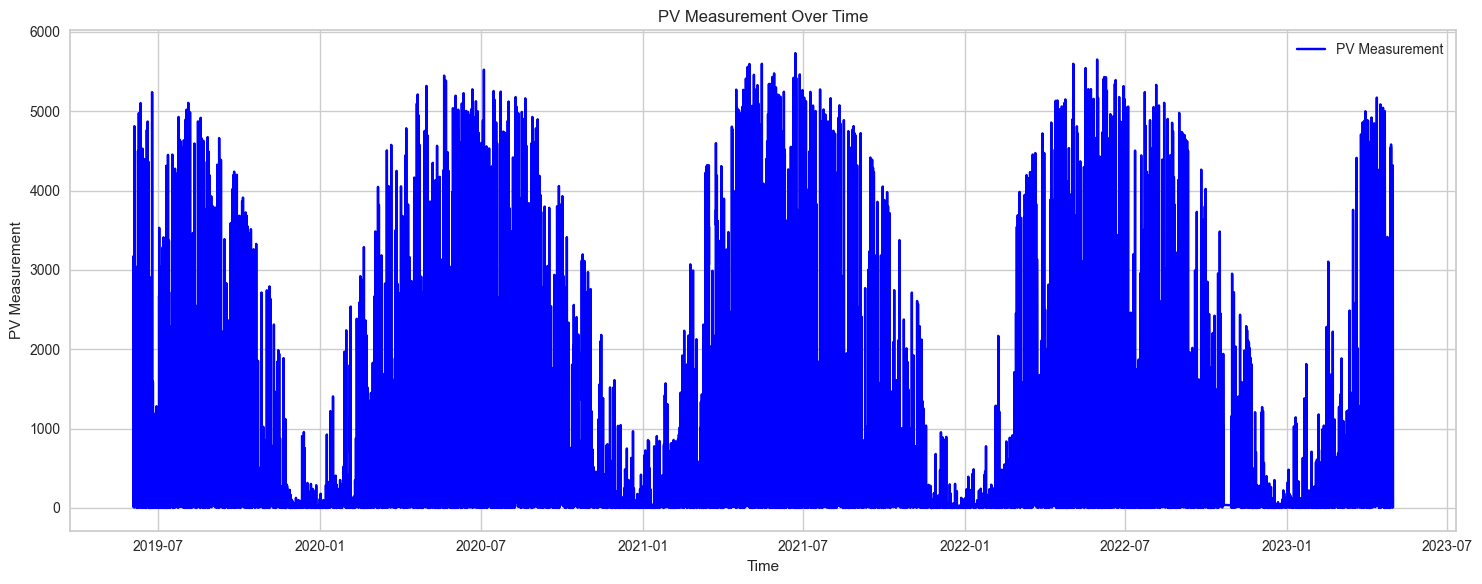

                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (18038, 54)
4        Transformed data shape  (18038, 66)
5   Transformed train set shape  (12626, 66)
6    Transformed test set shape   (5412, 66)
7              Ordinal features            1
8              Numeric features           50
9          Categorical features            3
10     Rows with missing values        19.9%
11                   Preprocess         True
12              Imputation type       simple
13           Numeric imputation         mean
14       Categorical imputation         mode
15     Maximum one-hot encoding           25
16              Encoding method         None
17               Fold Generator        KFold
18                  Fold Number           10
19                     CPU Jobs           -1
20                      Use GPU        False
21        

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     343.1896  281629.9252  530.6882  0.8407  0.9117  4.1828
1     305.0061  253285.3063  503.2746  0.8540  0.8599  2.6060
2     325.3754  277184.8739  526.4835  0.8493  0.8906  2.5567
3     342.7367  298598.9209  546.4421  0.8480  0.8479  2.8009
4     337.2962  294116.3854  542.3250  0.8348  0.8778  2.3554
5     351.0703  319241.1374  565.0143  0.8354  0.8084  1.7452
6     330.7766  286849.3129  535.5832  0.8479  0.8253  1.9725
7     341.0087  316699.0482  562.7602  0.8426  0.8577  2.5483
8     319.1093  271248.9254  520.8156  0.8516  0.8803  3.1128
9     342.4312  315338.1810  561.5498  0.8459  0.8630  2.8800
Mean  333.8000  291419.2017  539.4936  0.8450  0.8623  2.6761
Std    13.1529   20553.4314   19.1264  0.0062  0.0288  0.6339


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     332.7774  270349.9019  519.9518  0.8471  0.9262  4.9458
1     304.8743  245388.5184  495.3671  0.8586  0.8975  2.7863
2     323.9837  275618.4254  524.9937  0.8502  0.9214  2.9048
3     339.9517  301737.3548  549.3062  0.8464  0.8868  3.5801
4     336.0920  294251.8741  542.4499  0.8347  0.8744  2.5806
5     342.0899  306262.4364  553.4098  0.8421  0.8770  2.6410
6     325.4676  285466.4809  534.2906  0.8486  0.8544  2.5237
7     333.0848  301173.8213  548.7931  0.8503  0.9029  3.1106
8     326.1621  276669.2141  525.9935  0.8487  0.9029  3.1936
9     335.3457  309965.5504  556.7455  0.8485  0.8792  3.0849
Mean  329.9829  286688.3578  535.1301  0.8475  0.8923  3.1351
Std    10.1533   19014.5247   18.0028  0.0058  0.0211  0.6770


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     329.8967  264137.9460  513.9435  0.8506  0.8649  3.8362
1     301.4054  245381.6481  495.3601  0.8586  0.8272  2.3796
2     314.7326  266305.3135  516.0478  0.8552  0.8155  1.7619
3     330.0308  286742.5904  535.4835  0.8540  0.8223  2.6391
4     326.6421  283787.9741  532.7175  0.8406  0.8300  1.9851
5     332.4145  292388.3697  540.7295  0.8493  0.7765  1.7276
6     319.1511  280997.1612  530.0917  0.8510  0.7906  1.8486
7     327.5118  300597.5792  548.2678  0.8506  0.8380  2.4597
8     311.9375  262324.3910  512.1761  0.8565  0.8146  2.2732
9     332.3034  309584.5139  556.4032  0.8487  0.8161  2.6316
Mean  322.6026  279224.7487  528.1221  0.8515  0.8196  2.3543
Std     9.8798   18595.1003   17.6586  0.0048  0.0231  0.5923
Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be 

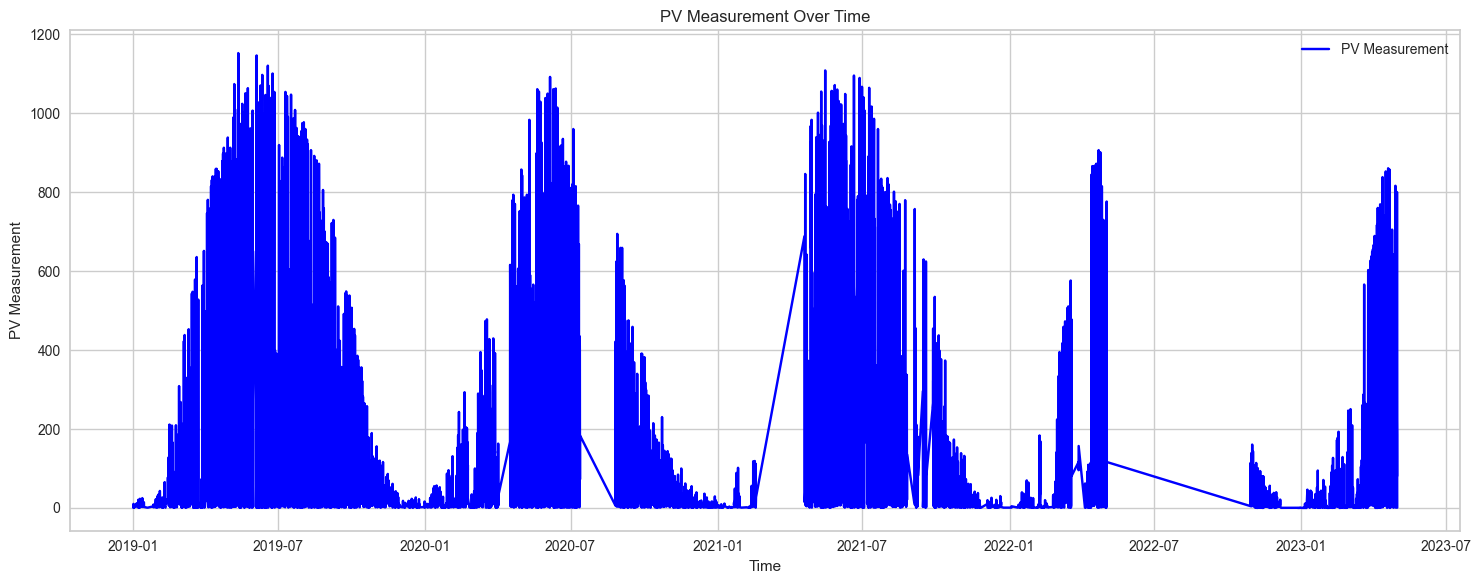

                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (12320, 54)
4        Transformed data shape  (12320, 66)
5   Transformed train set shape   (8624, 66)
6    Transformed test set shape   (3696, 66)
7              Ordinal features            1
8              Numeric features           50
9          Categorical features            3
10     Rows with missing values        17.1%
11                   Preprocess         True
12              Imputation type       simple
13           Numeric imputation         mean
14       Categorical imputation         mode
15     Maximum one-hot encoding           25
16              Encoding method         None
17               Fold Generator        KFold
18                  Fold Number           10
19                     CPU Jobs           -1
20                      Use GPU        False
21        

          MAE        MSE     RMSE      R2   RMSLE      MAPE
Fold                                                       
0     55.6008  8589.4606  92.6793  0.8838  0.7215    1.4831
1     53.8484  8233.6516  90.7395  0.8798  0.7757  144.3167
2     54.9546  8237.2023  90.7590  0.8866  0.7739    1.9685
3     48.9640  6522.9679  80.7649  0.8962  0.7552    1.8032
4     56.4835  8096.3377  89.9797  0.8648  0.6983    1.6224
5     53.6059  7880.2959  88.7710  0.8922  0.6743    2.2227
6     54.9539  8276.0566  90.9728  0.8729  0.7465    1.9167
7     53.0804  7960.5538  89.2219  0.8784  0.7493    2.1890
8     54.9961  8166.8878  90.3708  0.8702  0.7678    2.1612
9     50.7503  6629.4542  81.4215  0.9063  0.7059    1.3966
Mean  53.7238  7859.2868  88.5680  0.8831  0.7369   16.1080
Std    2.1846   667.0506   3.8714  0.0120  0.0332   42.7371


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     56.2647  8886.7857  94.2697  0.8798  0.6748   1.2480
1     54.3862  8398.0808  91.6410  0.8774  0.7475  39.3690
2     55.4600  8199.6703  90.5520  0.8871  0.7468   1.6308
3     50.1354  7068.4918  84.0743  0.8875  0.7058   1.6336
4     57.5939  8244.4574  90.7990  0.8623  0.7282   2.2816
5     54.2326  8375.5167  91.5178  0.8854  0.6460   2.0249
6     53.9424  8269.9342  90.9392  0.8730  0.6980   1.4118
7     54.3395  8632.6489  92.9120  0.8681  0.7282   2.1570
8     54.5839  8287.8966  91.0379  0.8683  0.7445   1.7469
9     52.2148  6991.1099  83.6129  0.9012  0.7207   1.4403
Mean  54.3153  8135.4592  90.1356  0.8790  0.7140   5.4944
Std    1.9485   586.8190   3.3217  0.0111  0.0317  11.2960


          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     55.6560  8575.2708  92.6028  0.8840  0.7037   1.4180
1     54.4200  8454.6438  91.9491  0.8765  0.7528  82.0479
2     54.8769  8338.8567  91.3173  0.8852  0.7689   1.9404
3     49.6707  6908.8982  83.1198  0.8900  0.7350   1.7504
4     56.2235  7992.3643  89.4000  0.8665  0.6944   1.5585
5     53.7161  7675.9846  87.6127  0.8950  0.6725   1.9119
6     54.1672  8159.4354  90.3296  0.8747  0.7381   1.8063
7     53.3357  8328.0342  91.2581  0.8728  0.7383   2.1388
8     53.7065  7819.5509  88.4282  0.8757  0.7517   1.9308
9     51.0607  6830.8224  82.6488  0.9034  0.7284   1.6115
Mean  53.6833  7908.3861  88.8666  0.8824  0.7284   9.8115
Std    1.8880   582.8072   3.3326  0.0107  0.0281  24.0797
Transformation Pipeline and Model Successfully Saved
The dataset starts from 2018-12-31 23:00:00 and ends at 2023-04-30 23:00:00


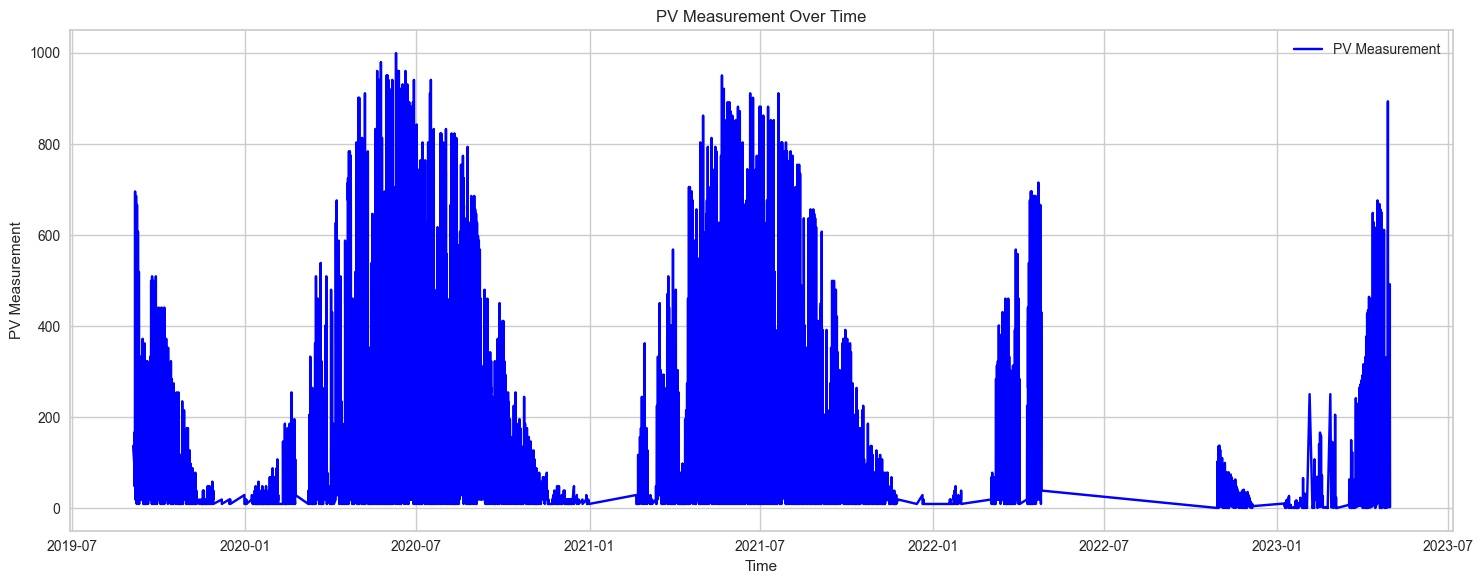

                    Description       Value
0                    Session id         123
1                        Target      target
2                   Target type  Regression
3           Original data shape  (9957, 54)
4        Transformed data shape  (9957, 66)
5   Transformed train set shape  (6969, 66)
6    Transformed test set shape  (2988, 66)
7              Ordinal features           1
8              Numeric features          50
9          Categorical features           3
10     Rows with missing values       23.0%
11                   Preprocess        True
12              Imputation type      simple
13           Numeric imputation        mean
14       Categorical imputation        mode
15     Maximum one-hot encoding          25
16              Encoding method        None
17               Fold Generator       KFold
18                  Fold Number          10
19                     CPU Jobs          -1
20                      Use GPU       False
21               Log Experiment 

          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     51.7392  7006.3188  83.7038  0.8614  0.5275  0.5875
1     45.5965  5421.7398  73.6325  0.8860  0.5590  0.6677
2     46.6496  6323.4236  79.5200  0.8642  0.5248  0.5577
3     46.1748  5782.0210  76.0396  0.8737  0.5114  0.6096
4     48.3448  6037.3105  77.7001  0.8705  0.5561  0.6510
5     46.2869  5441.1076  73.7639  0.8930  0.5416  0.6416
6     49.3669  6735.2585  82.0686  0.8361  0.5593  0.7259
7     46.4171  6019.5308  77.5856  0.8868  0.5113  0.5054
8     49.0224  6354.8434  79.7173  0.8748  0.4901  0.5202
9     46.3922  5317.5418  72.9215  0.8791  0.5815  0.7229
Mean  47.5990  6043.9096  77.6653  0.8726  0.5363  0.6190
Std    1.8538   540.9530   3.4661  0.0154  0.0266  0.0732


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     51.3196  6943.0210  83.3248  0.8627  0.5295  0.5318
1     45.1364  5413.2459  73.5748  0.8862  0.5244  0.6801
2     47.0245  6334.4415  79.5892  0.8639  0.5163  0.5362
3     50.0617  6683.1748  81.7507  0.8540  0.5486  0.6048
4     48.4125  6247.0667  79.0384  0.8660  0.5755  0.6553
5     46.3436  5584.6521  74.7305  0.8902  0.5207  0.5709
6     49.8283  6766.7745  82.2604  0.8354  0.6006  0.6902
7     48.3226  6596.4003  81.2182  0.8760  0.5272  0.5185
8     51.2351  6701.0531  81.8600  0.8680  0.5012  0.5187
9     48.5561  5963.5715  77.2242  0.8644  0.5653  0.6211
Mean  48.6240  6323.3401  79.4571  0.8667  0.5409  0.5928
Std    1.9407   493.6248   3.1476  0.0148  0.0293  0.0635


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     51.8402  7257.6758  85.1920  0.8564  0.5184  0.5927
1     45.3697  5510.9474  74.2358  0.8842  0.5281  0.6827
2     46.7922  6460.2511  80.3757  0.8612  0.5174  0.5728
3     46.9108  5862.0136  76.5638  0.8719  0.5275  0.6187
4     48.5509  6062.2661  77.8606  0.8700  0.5316  0.6252
5     46.8665  5647.6078  75.1506  0.8889  0.5135  0.6538
6     49.0398  6600.7073  81.2447  0.8394  0.5647  0.7572
7     45.6453  5729.2860  75.6920  0.8923  0.4967  0.5377
8     49.4447  6488.0374  80.5484  0.8722  0.4940  0.5480
9     46.4073  5499.2878  74.1572  0.8749  0.5510  0.6973
Mean  47.6867  6111.8080  78.1021  0.8711  0.5243  0.6286
Std    1.9018   545.6984   3.4460  0.0151  0.0208  0.0664
Transformation Pipeline and Model Successfully Saved


In [104]:
# LightGBM training and predictions
all_predictions_lGBM_e = []
for loc in locations:

    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
    
    # Calling preprocessing
    X_train_1, X_test_1, is_day_feature_1, targets_1 = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    
    # Adding the extra features to the test set as well
    X_train_1 = X_train_1.drop(columns=['date_forecast'])
    X_test_1['weighted_rad'] = ((X_test_1['direct_rad:W'] * (1 - X_test_1['total_cloud_cover:p']/100)) +
                        (X_test_1['diffuse_rad:W'] * (X_test_1['total_cloud_cover:p']/100)))

    X_test_1['adjusted_clear_sky_rad'] = (X_test_1['clear_sky_rad:W'] *
                                  np.exp(-0.0001 * X_test_1['absolute_humidity_2m:gm3']) *
                                  (1 - 0.1 * (X_test_1['air_density_2m:kgm3'] - 1.225)))
    
    # Training and prediction for diffrent seeds
    total_predictions_light = None
    seeds = [123]
    for seed in seeds: 
        final_model_lGBM_e = process_location_ex(X_train_1, targets_1, loc, seed)
        predictions_lGBM_e = predict_model(final_model_lGBM_e, data=X_test_1)
        final_predictions_lGBM_e = predictions_lGBM_e['prediction_label']
        if total_predictions_light is None:
            total_predictions_light = np.zeros_like(final_predictions_lGBM_e)
        total_predictions_light += final_predictions_lGBM_e

    mean_pred_light = total_predictions_light/len(seeds)

    # Multiplying the predictions with is_day, so setting predictions at night to zero
    adjusted_final_predictions_lGBM_e = mean_pred_light * is_day_feature_1['is_day:idx']

    # Setting negative predictions to zero
    adjusted_final_predictions_lGBM_e = np.clip(adjusted_final_predictions_lGBM_e, 0, None)

    # Appening predictions for each location to final list
    all_predictions_lGBM_e.append([adjusted_final_predictions_lGBM_e])

# Changing final list to array
all_predictions_lGBM_e = np.array(all_predictions_lGBM_e)

### Catboost model nr 1

The dataset starts from 2019-06-02 22:00:00 and ends at 2023-04-30 23:00:00


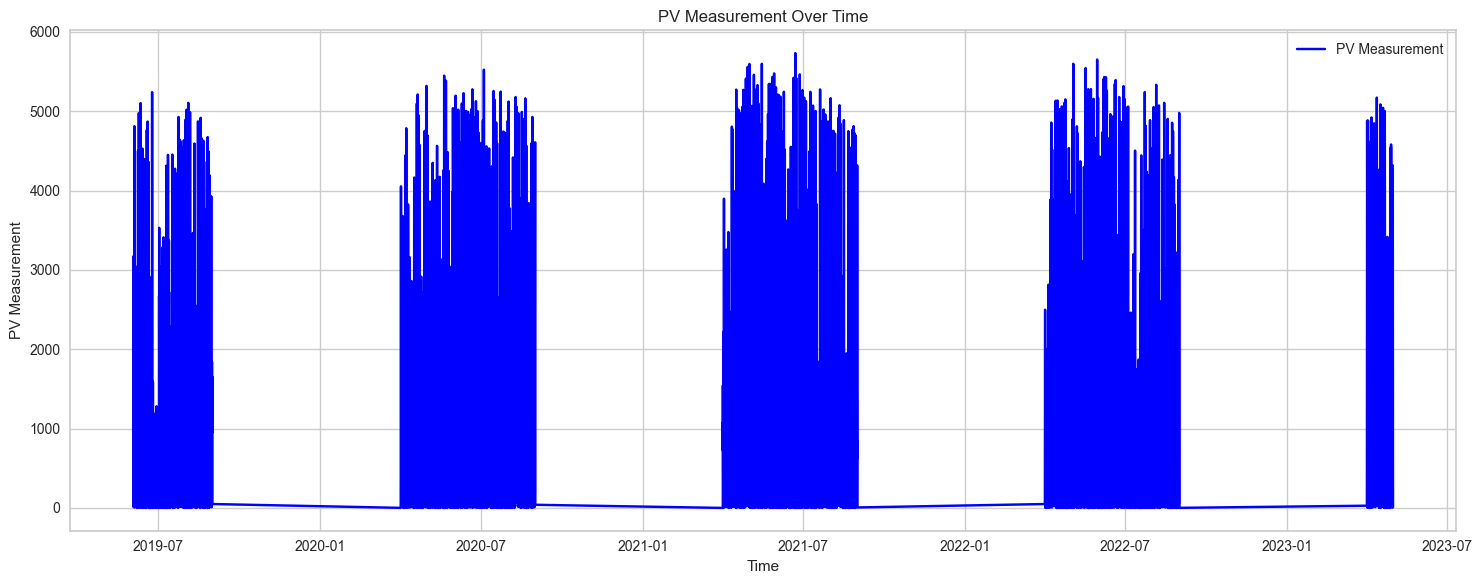

0:	learn: 1090.9157782	total: 57.4ms	remaining: 57.3s
200:	learn: 358.1621694	total: 10.7s	remaining: 42.5s
400:	learn: 328.0014967	total: 21s	remaining: 31.4s
600:	learn: 306.8545770	total: 31.9s	remaining: 21.2s
800:	learn: 290.9817303	total: 44.5s	remaining: 11.1s
999:	learn: 279.0102734	total: 57s	remaining: 0us
The dataset starts from 2018-12-31 23:00:00 and ends at 2023-04-30 23:00:00


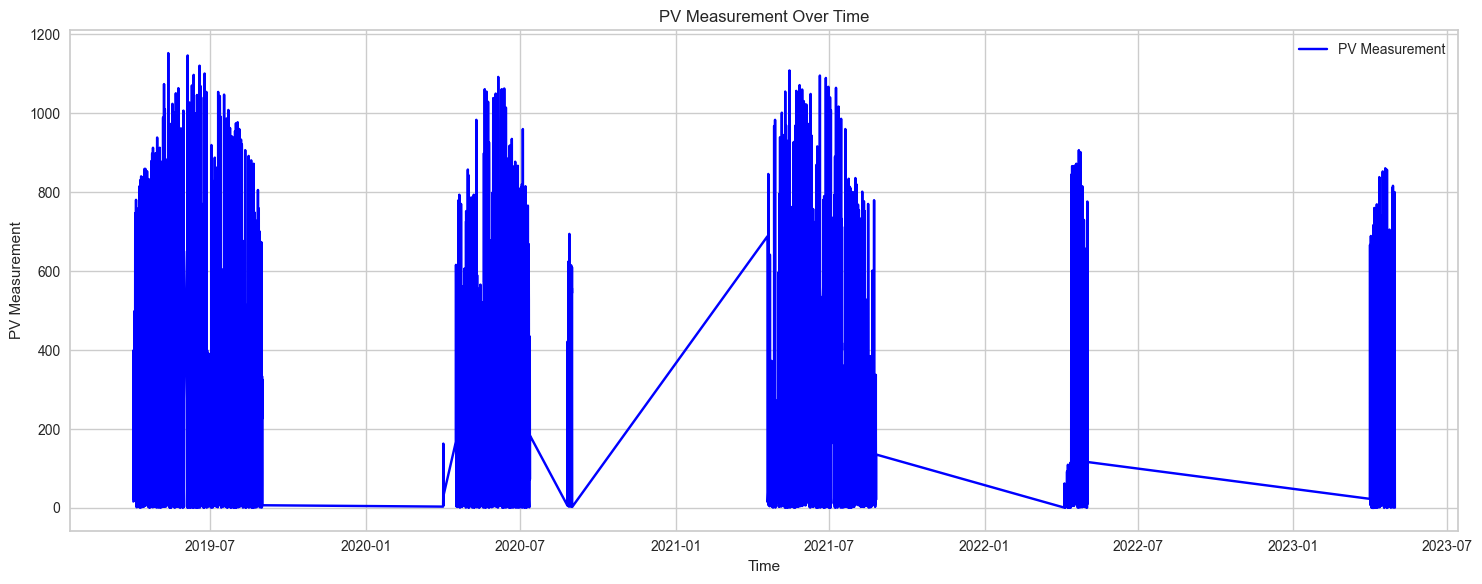

0:	learn: 217.5977385	total: 54.8ms	remaining: 54.7s
200:	learn: 62.6665806	total: 11.1s	remaining: 44.1s
400:	learn: 55.2419481	total: 21.9s	remaining: 32.8s
600:	learn: 50.6954414	total: 32.7s	remaining: 21.7s
800:	learn: 47.2839264	total: 43.6s	remaining: 10.8s
999:	learn: 44.8810197	total: 54.3s	remaining: 0us
The dataset starts from 2018-12-31 23:00:00 and ends at 2023-04-30 23:00:00


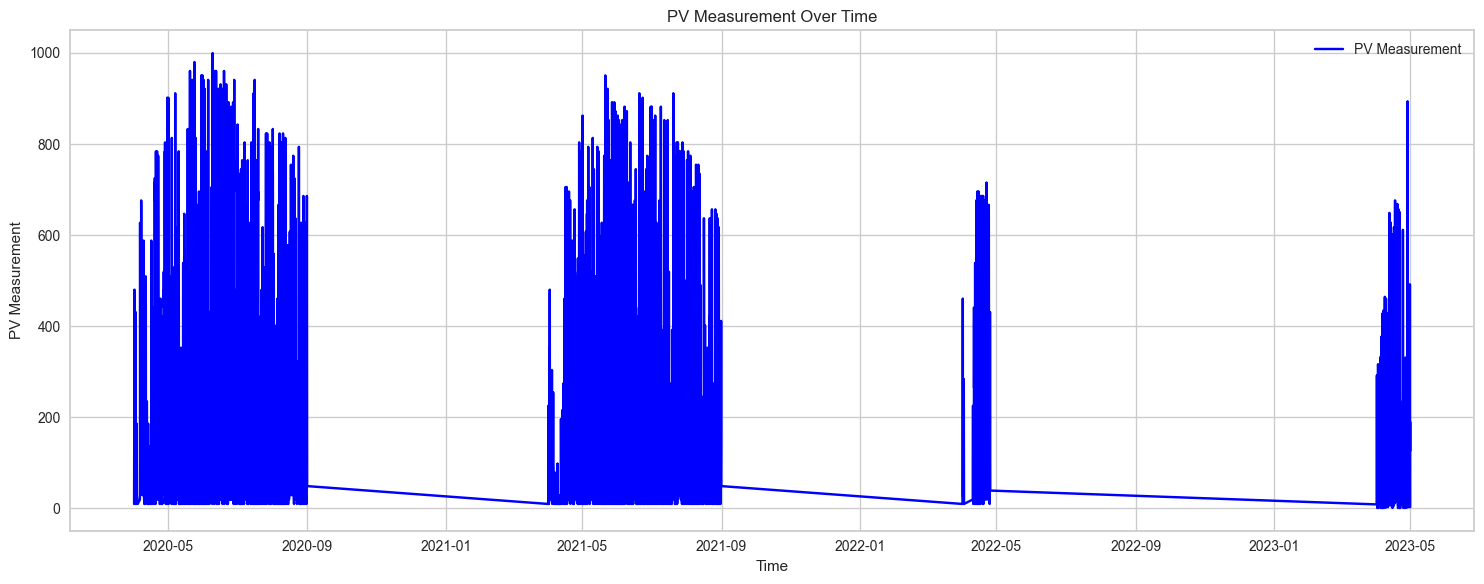

0:	learn: 180.4497730	total: 47.8ms	remaining: 47.8s
200:	learn: 52.5168909	total: 10.2s	remaining: 40.4s
400:	learn: 44.7827011	total: 20.2s	remaining: 30.1s
600:	learn: 40.7423801	total: 30.1s	remaining: 20s
800:	learn: 37.9544393	total: 40.1s	remaining: 9.95s
999:	learn: 35.7394194	total: 50.3s	remaining: 0us


In [105]:
all_predictions_cat = []
# Catboost model nr 1
for loc in locations:
    
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Calling preprocessing
    X_train_cat, X_test_cat, is_day_feature1, targets_cat = preprocessing_cat(train, X_train_observed, X_train_estimated, X_test_estimated)

    # Making categorical features
    cat_features = ['dew_or_rime:idx' ,'is_in_shadow:idx']
    X_train_cat['dew_or_rime:idx'] = X_train_cat['dew_or_rime:idx'].astype(int)
    X_train_cat['is_in_shadow:idx'] = X_train_cat['is_in_shadow:idx'].astype(int)
    X_test_cat['dew_or_rime:idx'] = X_test_cat['dew_or_rime:idx'].astype(int)
    X_test_cat['is_in_shadow:idx'] = X_test_cat['is_in_shadow:idx'].astype(int)

    # Catboooooooozt fun
    model_cat = CatBoostRegressor(
        loss_function='MAE', 
        learning_rate=0.1, 
        verbose=200,
        cat_features=cat_features,)
        #random_state=42,) 
        #n_estimators=20000,
        #early_stopping_rounds=50,)

    #X_train_cat1, X_val_cat1, y_train_cat1, y_val_cat1 = train_test_split(X_train_cat, targets_cat, test_size=0.2, random_state=42)
    
    # Training
    model_cat.fit(X_train_cat,targets_cat['pv_measurement']) #X_train_cat1, y_train_cat1['pv_measurement'],eval_set=(X_val_cat1, y_val_cat1['pv_measurement']),)

    # Prediction
    predictions_cat = model_cat.predict(X_test_cat)
    feature_importances = model_cat.get_feature_importance()
    # Multiplying the predictions with is_day, so setting predictions at night to zero
    adjusted_final_predictions_cat = predictions_cat * is_day_feature1['is_day:idx']

    # Setting negative predictions to zero
    adjusted_final_predictions_cat = np.clip(adjusted_final_predictions_cat, 0, None)

    # Appening predictions for each location to final list
    all_predictions_cat.append(adjusted_final_predictions_cat)

# Changing final list to array
all_predictions_cat = np.array(all_predictions_cat)

### Catboost model nr 2

The dataset starts from 2019-06-02 22:00:00 and ends at 2023-04-30 23:00:00


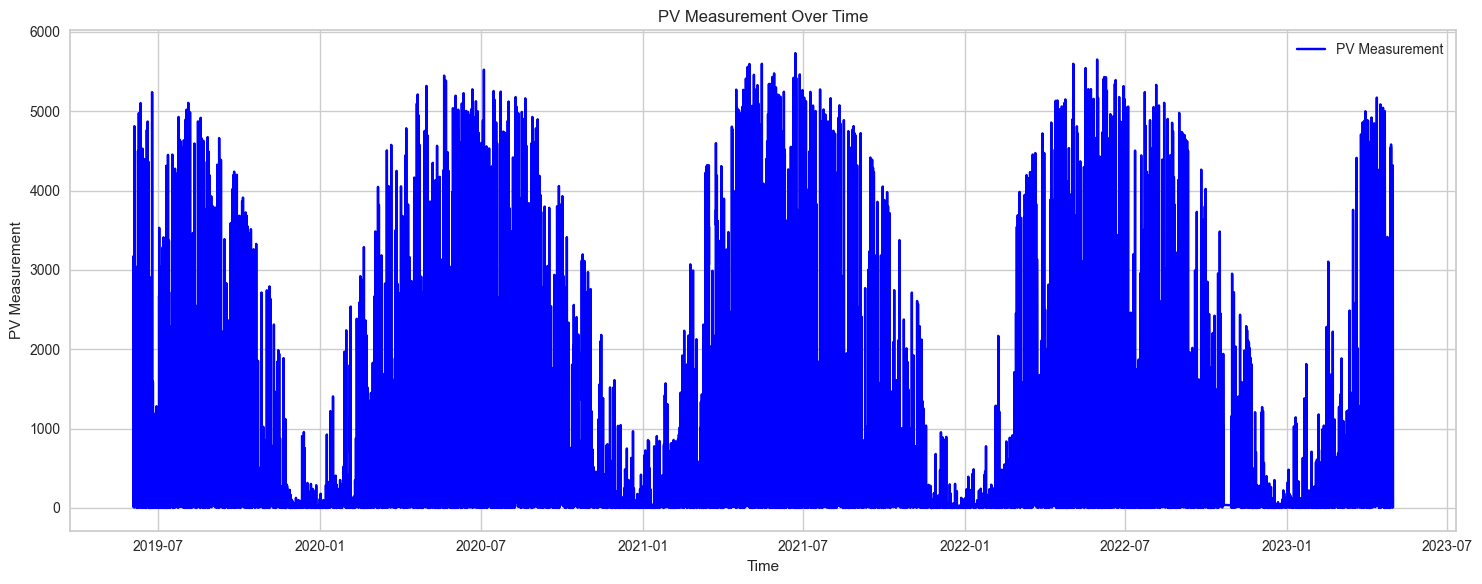

                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (18038, 40)
4        Transformed data shape  (18038, 40)
5   Transformed train set shape  (12626, 40)
6    Transformed test set shape   (5412, 40)
7              Numeric features           39
8      Rows with missing values        19.9%
9                    Preprocess         True
10              Imputation type       simple
11           Numeric imputation         mean
12       Categorical imputation         mode
13               Fold Generator        KFold
14                  Fold Number           10
15                     CPU Jobs           -1
16                      Use GPU        False
17               Log Experiment        False
18              Experiment Name        exp_A
19                          USI         a117


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     331.3666  259920.3198  509.8238  0.8530  1.0110  6.5280
1     299.2977  228399.8849  477.9120  0.8684  0.9630  3.4731
2     318.3407  261704.5500  511.5707  0.8577  0.9892  3.9995
3     332.5539  283428.1310  532.3797  0.8557  0.9474  3.8578
4     331.0788  280813.3368  529.9182  0.8422  0.9863  4.3077
5     339.1567  302922.5632  550.3840  0.8438  0.9185  3.1987
6     321.9943  272739.4426  522.2446  0.8554  0.9415  2.9431
7     338.0613  306552.9377  553.6722  0.8477  0.9662  3.7452
8     313.2529  253513.0610  503.5008  0.8613  0.9194  3.5048
9     330.2044  292077.6080  540.4420  0.8572  0.9726  3.7587
Mean  325.5307  274207.1835  523.1848  0.8543  0.9615  3.9317
Std    11.7550   22820.9990   22.0190  0.0076  0.0286  0.9415


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     342.3999  275739.5794  525.1091  0.8440  1.0649  7.2052
1     305.9462  238335.6150  488.1963  0.8627  1.0897  5.1373
2     327.5656  270290.7656  519.8950  0.8531  1.0764  5.1897
3     343.2952  290521.9505  539.0009  0.8521  1.0045  4.4782
4     339.4294  282483.8218  531.4921  0.8413  1.0556  5.5746
5     350.1891  315843.1184  561.9992  0.8372  0.9897  4.8072
6     334.5775  283472.5941  532.4214  0.8497  1.0206  4.3268
7     345.7109  311010.6446  557.6833  0.8454  1.0115  4.7126
8     329.0424  265605.9041  515.3697  0.8547  1.0048  4.3434
9     345.9808  307104.7513  554.1703  0.8499  1.0393  5.7253
Mean  336.4137  284040.8745  532.5337  0.8490  1.0357  5.1500
Std    12.3461   22365.6907   21.1827  0.0070

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     335.0717  267404.3956  517.1116  0.8488  0.9748  5.2834
1     301.5940  238116.7422  487.9721  0.8628  0.9204  3.0946
2     315.7882  256476.1804  506.4348  0.8606  0.9347  3.3105
3     331.1473  284198.5229  533.1027  0.8553  0.9053  3.1487
4     329.9422  281017.8757  530.1112  0.8421  0.9419  3.7127
5     338.8998  300344.0227  548.0365  0.8452  0.8343  2.4977
6     320.0438  278520.7622  527.7507  0.8523  0.8994  2.8530
7     334.8647  308656.2145  555.5684  0.8466  0.9224  3.4518
8     312.3860  261223.4811  511.1003  0.8571  0.8980  3.4360
9     332.8799  303607.0532  551.0055  0.8516  0.9163  3.4717
Mean  325.2618  277956.5251  526.8194  0.8522  0.9148  3.4260
Std    11.5410   21424.8198   20.4421  0.0064  0.0345  0.7018
Transformation Pipeline and Model Successfully Saved
The dataset starts from 2018-12-31 23:00:00 and ends at 2023-04-30 23:00:00


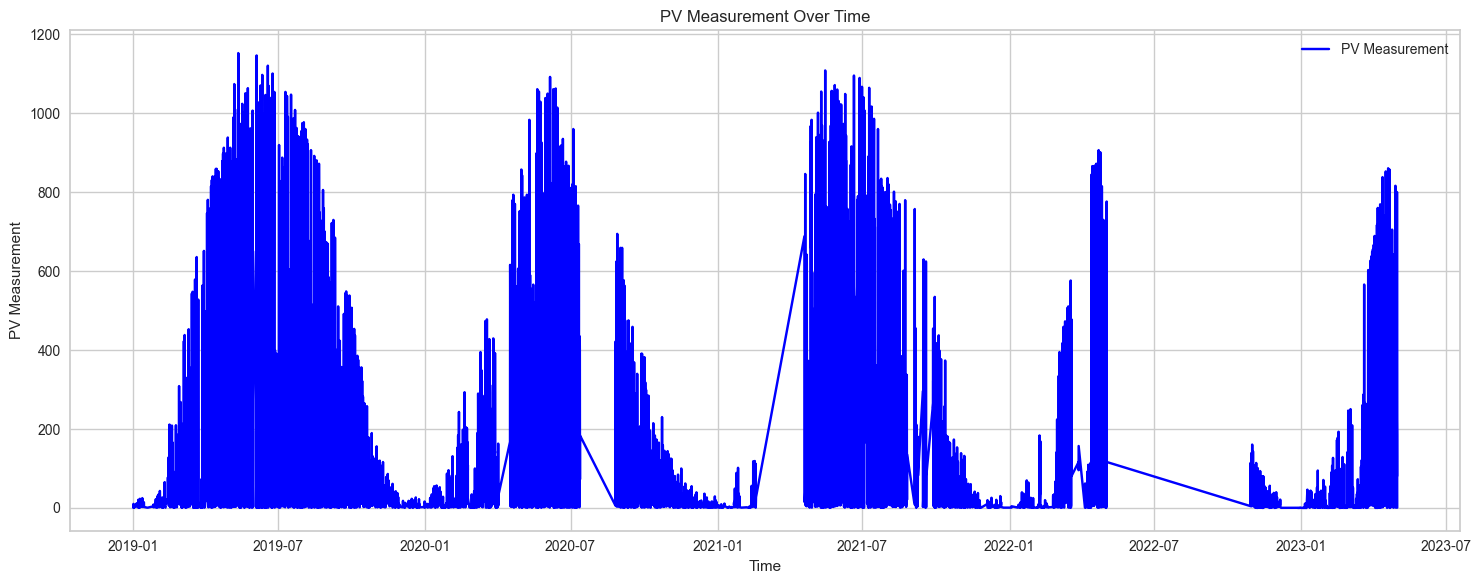

                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (12320, 40)
4        Transformed data shape  (12320, 40)
5   Transformed train set shape   (8624, 40)
6    Transformed test set shape   (3696, 40)
7              Numeric features           39
8      Rows with missing values        17.1%
9                    Preprocess         True
10              Imputation type       simple
11           Numeric imputation         mean
12       Categorical imputation         mode
13               Fold Generator        KFold
14                  Fold Number           10
15                     CPU Jobs           -1
16                      Use GPU        False
17               Log Experiment        False
18              Experiment Name        exp_B
19                          USI         bae8


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     54.4260  8360.0776  91.4335  0.8869  0.6943  1.2954
1     51.8050  7687.2368  87.6769  0.8877  0.7523  9.8224
2     52.8126  7961.9567  89.2298  0.8904  0.7473  1.6671
3     48.7370  6686.2347  81.7694  0.8936  0.7380  1.5727
4     54.8804  7808.7214  88.3670  0.8696  0.7020  3.3216
5     50.4343  7098.8269  84.2545  0.9029  0.6597  1.5482
6     53.6769  7988.3203  89.3774  0.8773  0.7352  1.6017
7     50.7821  7542.9776  86.8503  0.8848  0.7395  1.7046
8     51.3030  7363.7465  85.8123  0.8830  0.7519  1.7898
9     49.9294  6403.5049  80.0219  0.9095  0.7617  1.6786
Mean  51.8787  7490.1603  86.4793  0.8885  0.7282  2.6002
Std    1.9209   580.2465   3.3900  0.0110  0.0307  2.4642


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     55.1952  8206.3944  90.5892  0.8890  0.7616   1.4741
1     55.6615  8163.4795  90.3520  0.8808  0.8204  52.2870
2     56.7372  8540.8330  92.4166  0.8824  0.8376   1.8355
3     50.3860  6982.0360  83.5586  0.8888  0.7995   1.7922
4     58.3071  8298.8690  91.0981  0.8614  0.7676   4.2182
5     54.2339  7727.5603  87.9065  0.8943  0.7169   1.9616
6     54.9239  8380.0615  91.5427  0.8713  0.7495   1.8598
7     54.1524  8095.4948  89.9750  0.8763  0.8280   2.3333
8     54.8872  7897.2766  88.8666  0.8745  0.8480   2.7601
9     50.6251  6818.2325  82.5726  0.9036  0.7740   1.4778
Mean  54.5109  7911.0238  88.8878  0.8822  0.7903   7.2000
Std    2.3193   551.6472   3.1599  0.0116  0.0408  15.0487


          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     54.3831  8341.5211  91.3319  0.8872  0.7088   1.3335
1     52.3132  7848.7090  88.5929  0.8854  0.7450  37.8306
2     53.7241  8168.6231  90.3804  0.8875  0.7496   1.7543
3     48.8822  6718.0850  81.9639  0.8930  0.7268   1.5404
4     54.2424  7613.2155  87.2537  0.8728  0.6992   2.0381
5     51.5806  7323.8322  85.5794  0.8998  0.6785   1.6055
6     52.9891  7879.1435  88.7645  0.8790  0.7177   1.5544
7     51.6558  7830.5206  88.4902  0.8804  0.7261   1.5115
8     52.3322  7634.1735  87.3738  0.8787  0.7507   1.7898
9     49.7651  6554.5423  80.9601  0.9073  0.7383   1.5843
Mean  52.1868  7591.2366  87.0691  0.8871  0.7241   5.2542
Std    1.7184   548.9719   3.1950  0.0100  0.0223  10.8603
Transformation Pipeline and Model Successfully Saved
The dataset starts from 2018-12-31 23:00:00 and ends at 2023-04-30 23:00:00


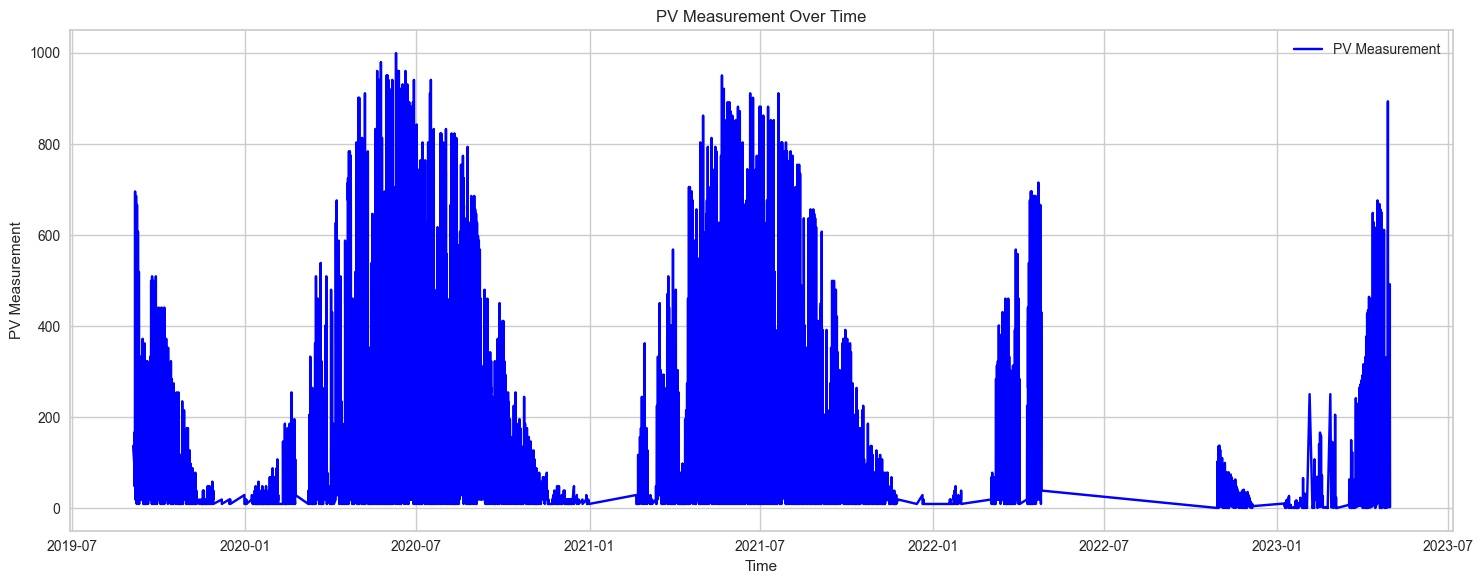

                    Description       Value
0                    Session id         123
1                        Target      target
2                   Target type  Regression
3           Original data shape  (9957, 40)
4        Transformed data shape  (9957, 40)
5   Transformed train set shape  (6969, 40)
6    Transformed test set shape  (2988, 40)
7              Numeric features          39
8      Rows with missing values       23.0%
9                    Preprocess        True
10              Imputation type      simple
11           Numeric imputation        mean
12       Categorical imputation        mode
13               Fold Generator       KFold
14                  Fold Number          10
15                     CPU Jobs          -1
16                      Use GPU       False
17               Log Experiment       False
18              Experiment Name       exp_C
19                          USI        6da8


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     48.9180  6581.3758  81.1257  0.8698  0.5343  0.5420
1     43.0463  4952.7755  70.3760  0.8959  0.5188  0.6307
2     44.2918  5645.2386  75.1348  0.8787  0.5351  0.5216
3     46.0072  5596.4060  74.8091  0.8777  0.5195  0.5632
4     45.1516  5447.7212  73.8087  0.8832  0.5209  0.5684
5     44.2861  5034.1173  70.9515  0.9010  0.5185  0.5782
6     47.4414  6224.3827  78.8948  0.8486  0.5688  0.7400
7     45.4593  5832.1280  76.3684  0.8904  0.5175  0.5270
8     46.4114  5898.6326  76.8026  0.8838  0.4859  0.5031
9     45.6208  5364.7953  73.2448  0.8780  0.5627  0.6578
Mean  45.6634  5657.7573  75.1516  0.8807  0.5282  0.5832
Std    1.5926   477.7395   3.1609  0.0139  0.0227  0.0694


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     49.3460  6462.7934  80.3915  0.8722  0.5684  0.5774
1     46.6861  5570.4980  74.6358  0.8829  0.6002  0.8404
2     45.5965  5795.8454  76.1304  0.8755  0.5495  0.5601
3     48.9760  6127.2254  78.2766  0.8662  0.5828  0.6110
4     47.7936  5975.2622  77.2998  0.8719  0.5925  0.6957
5     46.9345  5519.2069  74.2914  0.8914  0.5699  0.6340
6     51.0155  7159.4746  84.6137  0.8258  0.5835  0.6983
7     46.7735  6024.3660  77.6168  0.8867  0.5645  0.5608
8     48.6126  6269.1490  79.1780  0.8765  0.5375  0.5750
9     46.4283  5547.9191  74.4844  0.8738  0.5891  0.7374
Mean  47.8163  6045.1740  77.6918  0.8723  0.5738  0.6490
Std    1.5669   478.5055   3.0255  0.0171  0.0187  0.0878


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     49.7954  6827.5312  82.6289  0.8650  0.5049  0.5357
1     44.2238  5257.1606  72.5063  0.8895  0.5164  0.6358
2     45.1393  5943.2695  77.0926  0.8723  0.5179  0.5389
3     46.8191  5831.4639  76.3640  0.8726  0.5334  0.5886
4     46.5131  5808.6245  76.2143  0.8754  0.5440  0.5939
5     45.0005  5351.6283  73.1548  0.8947  0.5031  0.5682
6     48.4205  6526.4678  80.7866  0.8412  0.5605  0.7676
7     44.5649  5549.4067  74.4943  0.8957  0.4877  0.4903
8     47.3500  6069.8813  77.9094  0.8804  0.4896  0.5149
9     45.8832  5440.7113  73.7612  0.8762  0.5528  0.6648
Mean  46.3710  5860.6145  76.4912  0.8763  0.5210  0.5899
Std    1.6915   482.5825   3.1151  0.0152  0.0244  0.0780
Transformation Pipeline and Model Successfully Saved


In [108]:
all_predictions_cat_2 = []
# Catboost model nr 2
for loc in locations:
    
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Calling preprocessing
    X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)

    # Dropping some winter months
    X_train_cat_2 = X_train#[X_train['date_forecast'].dt.month.isin([3,4, 5, 6, 7, 8, 9,10])]

    # Dropping date feature
    X_train_cat_2 = X_train_cat_2.drop(columns=['date_forecast'])

    # Training and prediction for diffrent seeds
    seeds = [123]
    total_predictions_cat_2 = None
    for seed in seeds: 
        final_model_cat_2 = process_location_cat_2(X_train_cat_2, targets, loc,seed)#its aactually a catboost wohoo
        predictions_cat_2 = predict_model(final_model_cat_2, X_test)
        final_predictions_cat_2 = predictions_cat_2['prediction_label']
        if total_predictions_cat_2 is None:
            total_predictions_cat_2 = np.zeros_like(final_predictions_cat_2)
            total_predictions_cat_2+=final_predictions_cat_2

    mean_pred_cat_2 = total_predictions_cat_2/len(seeds)

    adjusted_final_predictions_cat_2 = mean_pred_cat_2 * is_day_feature['is_day:idx']
    adjusted_final_predictions_cat_2 = np.clip(adjusted_final_predictions_cat_2, 0, None)
    all_predictions_cat_2.append([adjusted_final_predictions_cat_2])
all_predictions_cat_2 = np.array(all_predictions_cat_2)

### Catboost model nr 3

The dataset starts from 2019-06-02 22:00:00 and ends at 2023-04-30 23:00:00


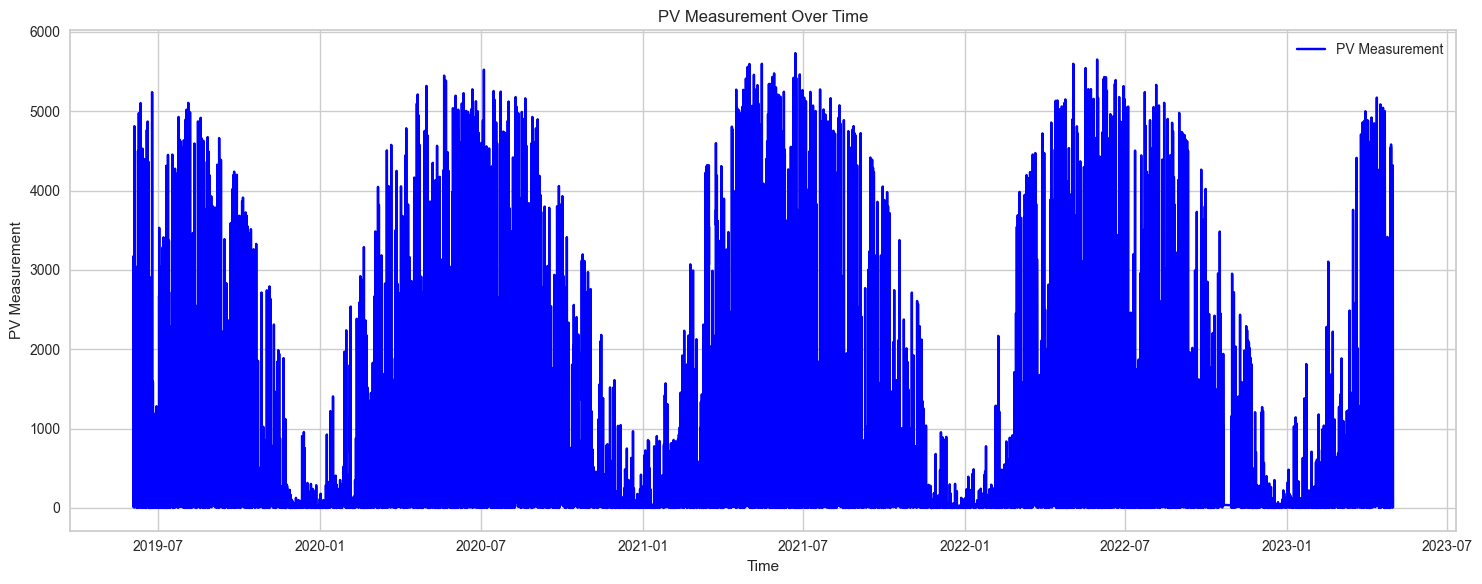

0:	learn: 981.0541229	test: 986.5219433	best: 986.5219433 (0)	total: 63.1ms	remaining: 21m 1s
200:	learn: 320.9450192	test: 341.6960508	best: 341.6960508 (200)	total: 12.4s	remaining: 20m 22s
400:	learn: 281.8109323	test: 323.5911619	best: 323.5911619 (400)	total: 24.5s	remaining: 19m 57s
600:	learn: 246.4965531	test: 313.0847849	best: 313.0847849 (600)	total: 36.7s	remaining: 19m 44s
800:	learn: 217.5035448	test: 306.7147854	best: 306.7147854 (800)	total: 48.9s	remaining: 19m 33s
1000:	learn: 190.6737885	test: 302.6330363	best: 302.6323358 (999)	total: 1m 1s	remaining: 19m 19s
1200:	learn: 174.3532699	test: 299.9268452	best: 299.9268452 (1200)	total: 1m 13s	remaining: 19m 4s
1400:	learn: 160.3087673	test: 297.9194447	best: 297.9095416 (1398)	total: 1m 25s	remaining: 18m 50s
1600:	learn: 150.9765890	test: 296.3387070	best: 296.3278847 (1598)	total: 1m 37s	remaining: 18m 36s
1800:	learn: 142.7118904	test: 295.0725273	best: 295.0579019 (1794)	total: 1m 49s	remaining: 18m 24s
2000:	learn:

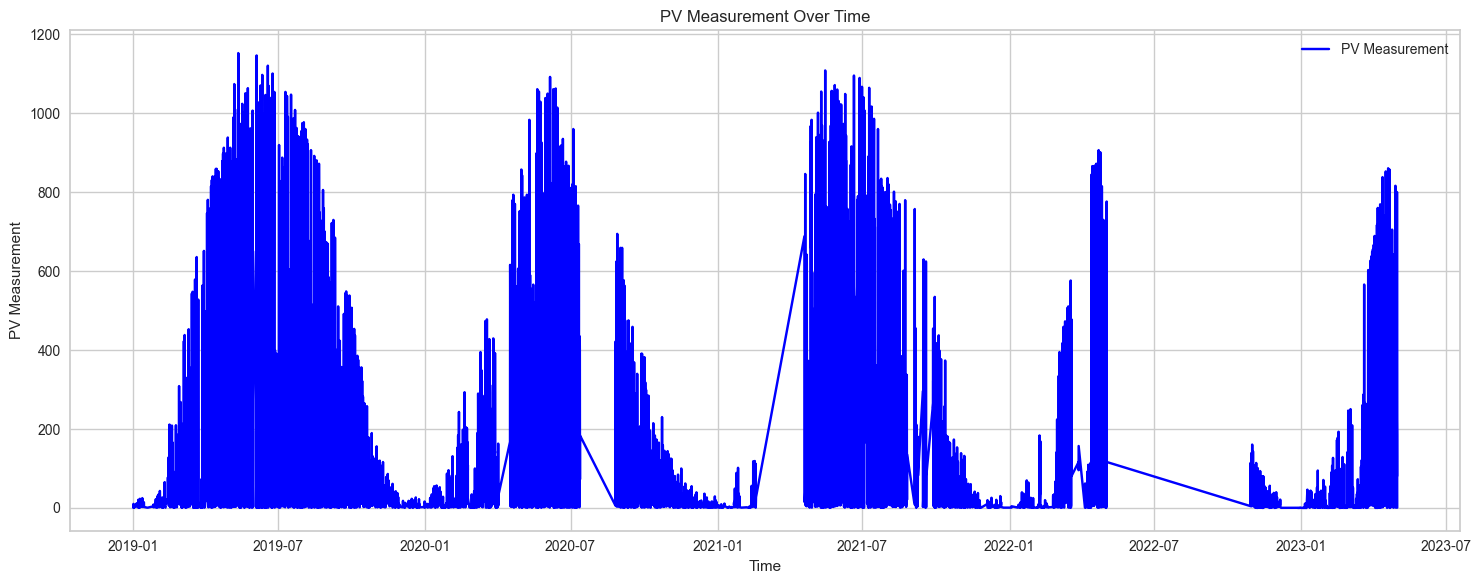

0:	learn: 185.0321347	test: 184.4813583	best: 184.4813583 (0)	total: 64.7ms	remaining: 21m 33s
200:	learn: 49.2267440	test: 54.5721107	best: 54.5721107 (200)	total: 14.4s	remaining: 23m 42s
400:	learn: 40.0148888	test: 51.0957403	best: 51.0957403 (400)	total: 27.1s	remaining: 22m 6s
600:	learn: 33.8173131	test: 49.5168721	best: 49.5160368 (598)	total: 40.3s	remaining: 21m 39s
800:	learn: 28.5978575	test: 48.4759509	best: 48.4759509 (800)	total: 52.8s	remaining: 21m 6s
1000:	learn: 25.1718747	test: 47.8269326	best: 47.8269204 (999)	total: 1m 5s	remaining: 20m 39s
1200:	learn: 22.8856085	test: 47.4411204	best: 47.4411204 (1200)	total: 1m 17s	remaining: 20m 16s
1400:	learn: 20.8544290	test: 47.1394490	best: 47.1394490 (1400)	total: 1m 30s	remaining: 19m 59s
1600:	learn: 18.9670975	test: 46.9528789	best: 46.9483283 (1597)	total: 1m 42s	remaining: 19m 39s
1800:	learn: 17.4139992	test: 46.7346479	best: 46.7266873 (1780)	total: 1m 54s	remaining: 19m 22s
2000:	learn: 16.1359137	test: 46.605311

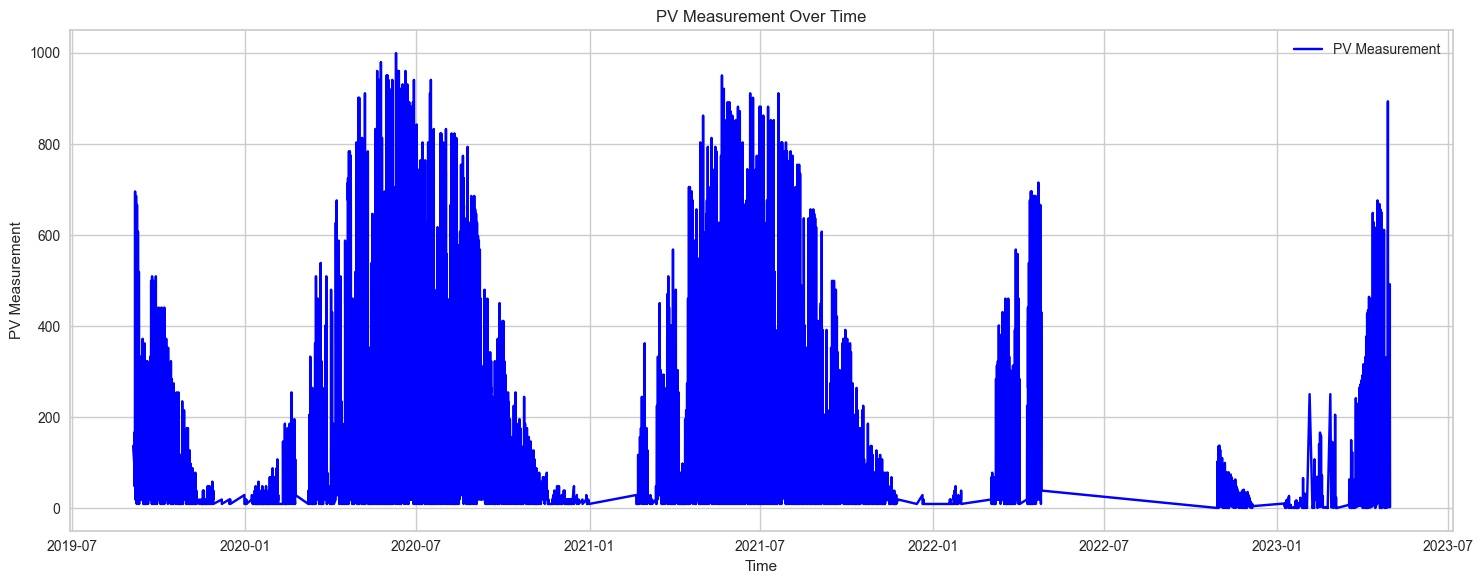

0:	learn: 152.8243626	test: 157.7285790	best: 157.7285790 (0)	total: 69.7ms	remaining: 23m 12s
200:	learn: 43.5613166	test: 49.1860538	best: 49.1860538 (200)	total: 12.6s	remaining: 20m 41s
400:	learn: 35.4510657	test: 45.7833274	best: 45.7833274 (400)	total: 25.1s	remaining: 20m 27s
600:	learn: 29.2330753	test: 43.7454151	best: 43.7454151 (600)	total: 37.7s	remaining: 20m 17s
800:	learn: 24.7716296	test: 42.6670553	best: 42.6640382 (797)	total: 50s	remaining: 19m 57s
1000:	learn: 21.7026201	test: 42.0395841	best: 42.0391080 (999)	total: 1m 2s	remaining: 19m 41s
1200:	learn: 19.3212459	test: 41.5825111	best: 41.5825111 (1200)	total: 1m 14s	remaining: 19m 22s
1400:	learn: 17.5308989	test: 41.1592840	best: 41.1592840 (1400)	total: 1m 28s	remaining: 19m 31s
1600:	learn: 15.8723877	test: 40.8992881	best: 40.8992881 (1600)	total: 1m 40s	remaining: 19m 15s
1800:	learn: 14.5497538	test: 40.6476987	best: 40.6476987 (1800)	total: 1m 52s	remaining: 18m 59s
2000:	learn: 13.6785206	test: 40.475283

In [109]:
# Catboost model nr 3
for loc in locations:
    
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Calling preprocessing
    X_train_3, X_test_3, is_day_feature_3, targets_3 = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)

    # Dropping date feature
    X_train_3 = X_train_3.drop(columns=['date_forecast'])
    
    # Catboooooooozt fun round 3 wohoo
    model_cat_3 = CatBoostRegressor(
    verbose=200, 
    learning_rate=0.03,
    depth=10,
    l2_leaf_reg=5,
    random_state=42, 
    n_estimators=20000, 
    loss_function='MAE', 
    early_stopping_rounds=100,)

    # Create 'sin_sun_azimuth' and 'cos_sun_azimuth' from 'sun_azimuth' in radians
    X_train_3['sin_sun_azimuth'] = np.sin(np.radians(X_train_3['sun_azimuth:d']))
    X_train_3['cos_sun_azimuth'] = np.cos(np.radians(X_train_3['sun_azimuth:d']))
    X_test_3['sin_sun_azimuth'] = np.sin(np.radians(X_test_3['sun_azimuth:d']))
    X_test_3['cos_sun_azimuth'] = np.cos(np.radians(X_test_3['sun_azimuth:d']))

    # Now drop the original 'sun_azimuth' feature
    X_train_3.drop('sun_azimuth:d', axis=1, inplace=True)
    X_test_3.drop('sun_azimuth:d', axis=1, inplace=True)

    # Split the training data into training and validation sets
    X_train_cat_3, X_test_cat_3, y_train_cat_3, y_test_cat_3 = train_test_split(X_train_3, targets_3, test_size=0.2, random_state=42)

    # Train model
    model_cat_3.fit(X_train_cat_3, y_train_cat_3['pv_measurement'],eval_set=(X_test_cat_3, y_test_cat_3['pv_measurement']),)  
    
    # Pred
    pred_cat_3 = model_cat_3.predict(X_test_3)

    # Multiplying the predictions with is_day, so setting predictions at night to zero
    adjusted_final_predictions_cat_3 = pred_cat_3 * is_day_feature_3['is_day:idx']

    # Setting negative predictions to zero
    adjusted_final_predictions_cat_3 = np.clip(adjusted_final_predictions_cat_3, 0, None)

    # Appening predictions for each location to final list
    all_predictions_cat_3.append(adjusted_final_predictions_cat_3) 

# Changing final list to array   
all_predictions_cat_3 = np.array(all_predictions_cat_3)

### Random forest model

The dataset starts from 2019-06-02 22:00:00 and ends at 2023-04-30 23:00:00


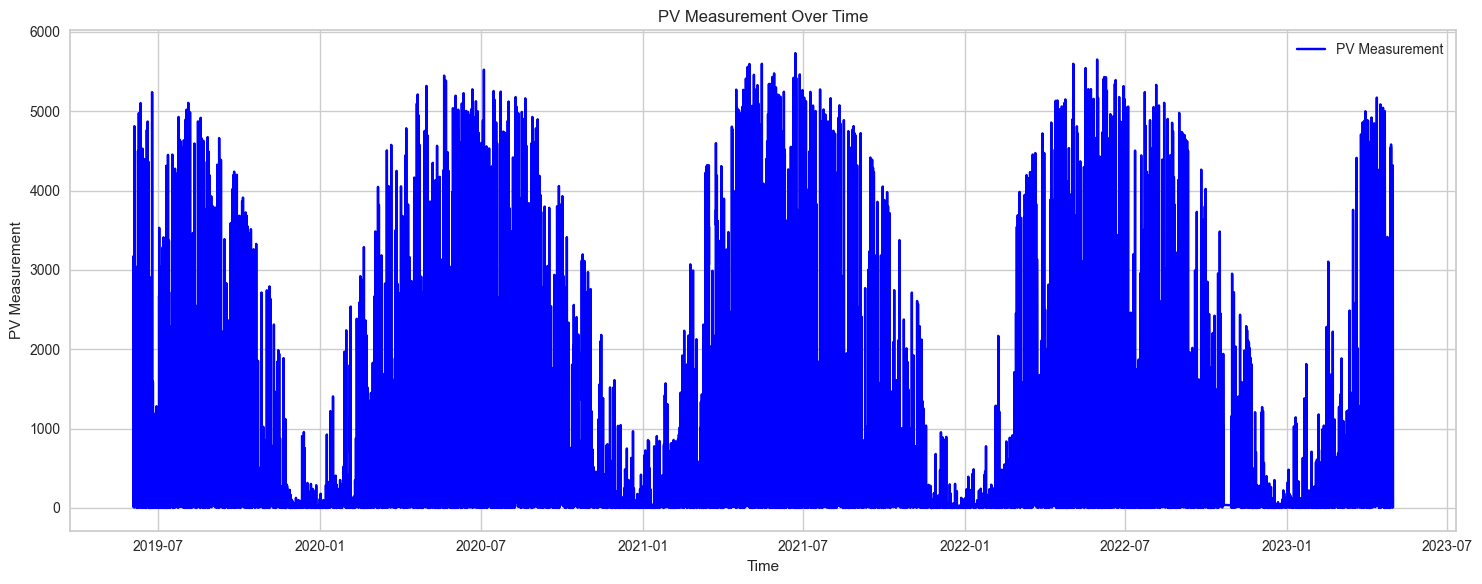

                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (13581, 53)
4        Transformed data shape  (13581, 65)
5   Transformed train set shape   (9506, 65)
6    Transformed test set shape   (4075, 65)
7              Ordinal features            1
8              Numeric features           49
9          Categorical features            3
10     Rows with missing values        20.6%
11                   Preprocess         True
12              Imputation type       simple
13           Numeric imputation         mean
14       Categorical imputation         mode
15     Maximum one-hot encoding           25
16              Encoding method         None
17               Fold Generator        KFold
18                  Fold Number           10
19                     CPU Jobs           -1
20                      Use GPU        False
21        

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     382.6635  374253.0195  611.7622  0.8059  0.5803  0.8330
1     385.3473  370838.1778  608.9648  0.8255  0.6183  1.1285
2     376.2969  355207.9221  595.9932  0.8353  0.6118  0.9036
3     394.0273  379629.9249  616.1412  0.8303  0.6035  0.8105
4     392.2871  369224.8572  607.6388  0.8326  0.6622  1.4119
5     383.6170  353936.6879  594.9258  0.8352  0.6404  1.0071
6     375.3479  333433.8260  577.4373  0.8400  0.6266  0.9326
7     414.0942  429068.2293  655.0330  0.8079  0.6106  1.1142
8     404.4677  422992.8411  650.3790  0.8054  0.6580  1.2091
9     396.9308  403158.4095  634.9476  0.8045  0.6485  0.9230
Mean  390.5080  379174.3895  615.3223  0.8223  0.6260  1.0273
Std    11.7278   29122.3805   23.5133  0.0138  0.0248  0.1786


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     380.2591  361089.8387  600.9075  0.8128  0.6056  0.9675
1     391.6278  376970.0551  613.9789  0.8227  0.6648  1.3461
2     373.3981  342869.2443  585.5504  0.8410  0.6603  1.2351
3     392.1618  375370.2696  612.6747  0.8322  0.6300  1.0103
4     400.3206  376034.9296  613.2169  0.8295  0.6848  1.6632
5     388.2062  360493.6331  600.4112  0.8321  0.6768  1.2835
6     381.9138  344570.3023  587.0011  0.8347  0.6665  1.1475
7     419.5372  428609.1012  654.6824  0.8081  0.6510  1.4763
8     412.7244  426004.5609  652.6902  0.8040  0.7006  1.4392
9     400.8695  401340.8656  633.5147  0.8053  0.6904  1.2122
Mean  394.1018  379335.2800  615.4628  0.8222  0.6631  1.2781
Std    13.7539   28894.0550   23.2555  0.0129

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     381.2520  354438.8040  595.3476  0.8162  0.5858  0.8468
1     388.4340  352088.8911  593.3708  0.8344  0.6260  1.1425
2     373.7037  335799.9443  579.4825  0.8443  0.6215  0.9703
3     397.9867  372914.5400  610.6673  0.8333  0.6148  0.8511
4     393.7506  352843.7476  594.0065  0.8400  0.6672  1.4662
5     385.8045  347671.4204  589.6367  0.8381  0.6543  1.0937
6     375.4003  323293.6705  568.5892  0.8449  0.6390  0.9997
7     416.2431  406596.5770  637.6493  0.8179  0.6295  1.2784
8     410.4130  411904.7001  641.7980  0.8105  0.6836  1.3745
9     398.5264  386472.0944  621.6688  0.8126  0.6591  0.9936
Mean  392.1514  364402.4389  603.2217  0.8292  0.6381  1.1017
Std    13.3602   27872.5618   22.9360  0.0128  0.0272  0.2018
Transformation Pipeline and Model Successfully Saved
The dataset starts from 2018-12-31 23:00:00 and ends at 2023-04-30 23:00:00


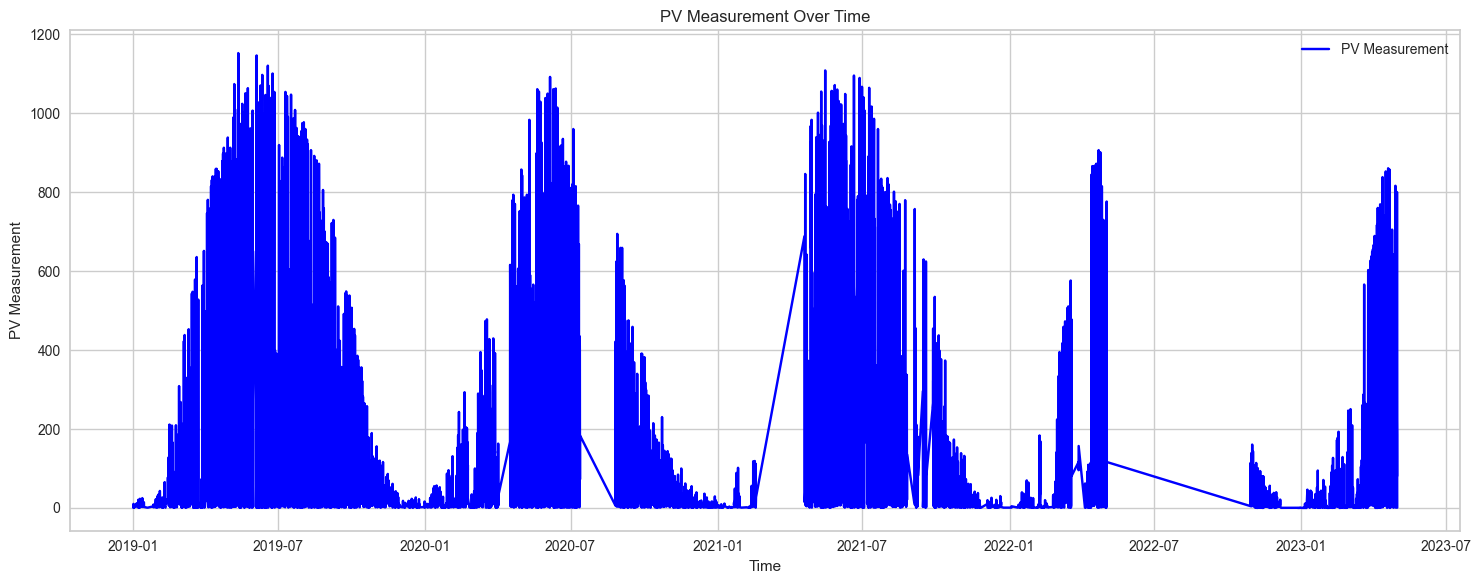

                    Description       Value
0                    Session id         123
1                        Target      target
2                   Target type  Regression
3           Original data shape  (9223, 53)
4        Transformed data shape  (9223, 64)
5   Transformed train set shape  (6456, 64)
6    Transformed test set shape  (2767, 64)
7              Ordinal features           1
8              Numeric features          49
9          Categorical features           3
10     Rows with missing values       17.9%
11                   Preprocess        True
12              Imputation type      simple
13           Numeric imputation        mean
14       Categorical imputation        mode
15     Maximum one-hot encoding          25
16              Encoding method        None
17               Fold Generator       KFold
18                  Fold Number          10
19                     CPU Jobs          -1
20                      Use GPU       False
21               Log Experiment 

          MAE         MSE      RMSE      R2   RMSLE      MAPE
Fold                                                         
0     68.3113  11343.0339  106.5037  0.8542  0.7011    1.2244
1     62.6619   8939.4725   94.5488  0.8777  0.6479    0.9673
2     64.7446  10445.9213  102.2053  0.8691  0.6452    1.1760
3     65.7975  11157.0932  105.6271  0.8613  0.6475    1.4894
4     72.4574  13408.3808  115.7946  0.8203  0.6336    1.1350
5     67.2949  10863.1008  104.2262  0.8607  0.6772    1.6196
6     65.5003   9541.3144   97.6797  0.8660  0.6475    1.1340
7     69.1005  11800.5150  108.6302  0.8383  0.6560    1.1710
8     67.4606  11196.8791  105.8153  0.8548  0.6465  130.0564
9     68.4961  10544.0578  102.6843  0.8658  0.6979    1.6707
Mean  67.1825  10923.9769  104.3715  0.8568  0.6600   14.1644
Std    2.5636   1160.6724    5.5286  0.0157  0.0224   38.6313


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


          MAE         MSE      RMSE      R2   RMSLE      MAPE
Fold                                                         
0     70.8919  11577.2851  107.5978  0.8512  0.7206    1.2488
1     64.5907   9288.0336   96.3744  0.8729  0.6571    1.0056
2     66.8011  10486.9883  102.4060  0.8685  0.6714    1.3885
3     66.5059  10953.5515  104.6592  0.8638  0.6430    1.6962
4     72.9667  12649.1287  112.4683  0.8305  0.6625    1.2903
5     69.0375  10792.8242  103.8885  0.8616  0.6843    1.4108
6     65.4010   9459.7312   97.2611  0.8671  0.6454    1.0201
7     69.9108  11321.5126  106.4026  0.8449  0.7046    1.4239
8     68.7695  11237.9519  106.0092  0.8543  0.6627  120.5538
9     71.8112  11111.1414  105.4094  0.8586  0.7388    1.8294
Mean  68.6686  10887.8149  104.2477  0.8573  0.6790   13.2867
Std    2.6543    933.3215    4.4988  0.0120  0.0308   35.7565
RandomForestRegressor(bootstrap=False, max_depth=11, max_features='sqrt',
                      min_impurity_decrease=0.0002, min_sa

          MAE         MSE      RMSE      R2   RMSLE      MAPE
Fold                                                         
0     72.4594  11320.2292  106.3966  0.8545  0.7843    1.5673
1     66.4937   9219.6185   96.0188  0.8738  0.7147    1.2583
2     68.3355  10288.6575  101.4330  0.8710  0.7297    1.8318
3     67.3903  10407.4178  102.0168  0.8706  0.7012    2.2733
4     73.5426  12252.1004  110.6892  0.8358  0.7195    1.6381
5     70.2123  10554.0715  102.7330  0.8646  0.7606    1.9840
6     67.5684   9517.0574   97.5554  0.8663  0.7178    1.4266
7     70.6244  10907.6422  104.4397  0.8506  0.7744    1.8807
8     69.5539  10769.4173  103.7758  0.8604  0.7376  306.4220
9     74.0544  11050.1137  105.1195  0.8594  0.8105    2.3353
Mean  70.0235  10628.6326  103.0178  0.8607  0.7450   32.2618
Std    2.5190    823.4237    3.9962  0.0109  0.0338   91.3873
Transformation Pipeline and Model Successfully Saved
The dataset starts from 2018-12-31 23:00:00 and ends at 2023-04-30 23:00:00


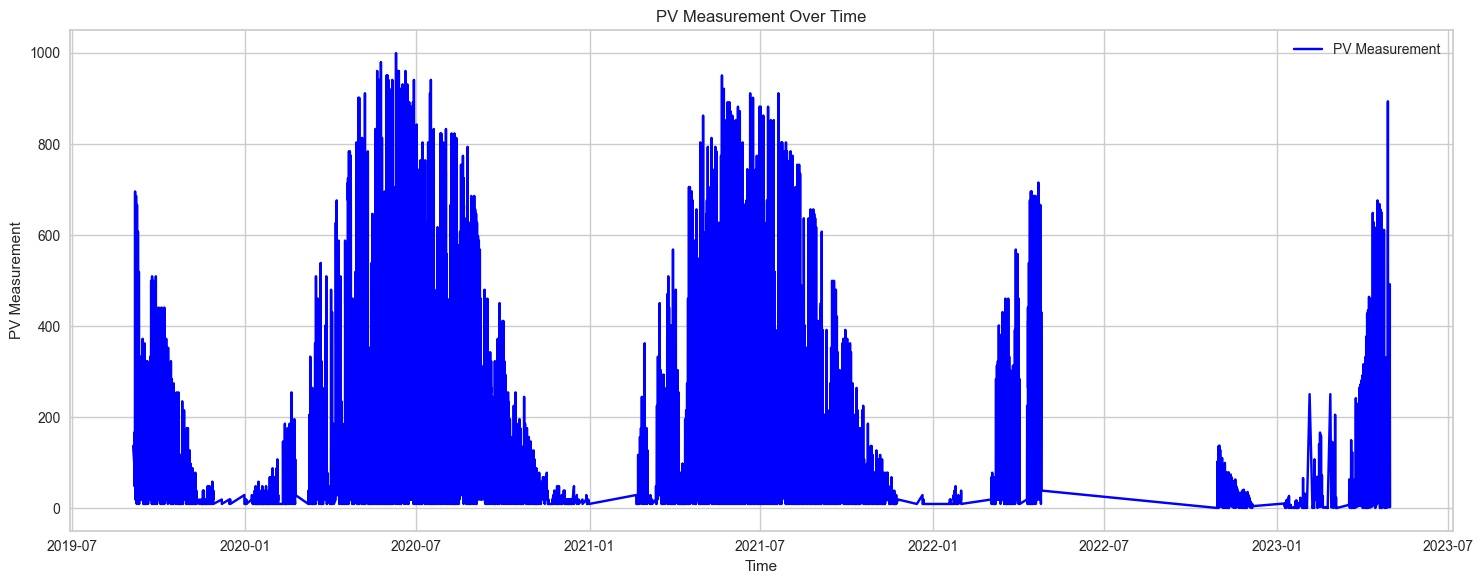

                    Description       Value
0                    Session id         123
1                        Target      target
2                   Target type  Regression
3           Original data shape  (7790, 53)
4        Transformed data shape  (7790, 65)
5   Transformed train set shape  (5453, 65)
6    Transformed test set shape  (2337, 65)
7              Ordinal features           1
8              Numeric features          49
9          Categorical features           3
10     Rows with missing values       24.6%
11                   Preprocess        True
12              Imputation type      simple
13           Numeric imputation        mean
14       Categorical imputation        mode
15     Maximum one-hot encoding          25
16              Encoding method        None
17               Fold Generator       KFold
18                  Fold Number          10
19                     CPU Jobs          -1
20                      Use GPU       False
21               Log Experiment 

          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     57.5449  8440.8060  91.8739  0.8437  0.5465  0.6618
1     53.2259  7064.8182  84.0525  0.8434  0.4840  0.5112
2     57.6482  8067.7513  89.8207  0.8438  0.6107  0.9202
3     60.6501  8512.3607  92.2625  0.8514  0.5090  0.5753
4     60.5570  8813.5677  93.8806  0.8097  0.5172  0.5995
5     58.0031  7973.4375  89.2941  0.8333  0.5730  0.8589
6     58.5037  7924.3654  89.0189  0.8478  0.5105  0.6076
7     53.9248  7093.6534  84.2238  0.8415  0.5545  0.7844
8     60.5072  8013.0446  89.5156  0.8563  0.5406  0.7064
9     57.5871  7810.3757  88.3763  0.8557  0.5663  0.7236
Mean  57.8152  7971.4180  89.2319  0.8427  0.5412  0.6949
Std    2.4425   534.2022   3.0148  0.0128  0.0354  0.1235


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     58.8450  8651.6127  93.0140  0.8398  0.5636  0.7161
1     55.3333  7386.5189  85.9449  0.8363  0.5015  0.5451
2     57.6619  7935.2237  89.0799  0.8464  0.6126  0.9182
3     61.8197  8478.7533  92.0801  0.8519  0.5176  0.6463
4     60.2059  8428.1965  91.8052  0.8180  0.5193  0.6180
5     59.1523  8074.0877  89.8559  0.8312  0.5688  0.8326
6     58.7433  7799.6878  88.3158  0.8502  0.5194  0.6424
7     53.7481  7076.3740  84.1212  0.8419  0.5537  0.8013
8     60.3604  7775.7756  88.1804  0.8606  0.5494  0.7397
9     57.6414  7762.2800  88.1038  0.8566  0.5687  0.7231
Mean  58.3511  7936.8510  89.0501  0.8433  0.5475  0.7183
Std    2.2764   467.2601   2.6318  0.0121  0.0317  0.1056
RandomForestRegressor(bootstrap=False, max_depth=11, max_features='sqrt',
                      min_impurity_decrease=0.0002, min_samples_leaf=5,
                      min_samples_split=7,

          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     59.4977  8163.5088  90.3521  0.8488  0.5761  0.7502
1     55.1053  6936.5970  83.2862  0.8462  0.5138  0.5820
2     58.3141  7681.2790  87.6429  0.8513  0.6239  0.9596
3     63.4409  8353.8394  91.3993  0.8541  0.5382  0.7033
4     61.7070  8385.9898  91.5751  0.8189  0.5322  0.6555
5     59.0490  7619.8367  87.2917  0.8407  0.5742  0.8479
6     58.7493  7530.3175  86.7774  0.8554  0.5345  0.6732
7     54.6929  6939.9115  83.3061  0.8449  0.5650  0.8465
8     61.1738  7580.6099  87.0667  0.8641  0.5593  0.7962
9     58.7912  7768.7845  88.1407  0.8565  0.5809  0.7601
Mean  59.0521  7696.0674  87.6838  0.8481  0.5598  0.7575
Std    2.5748   482.4776   2.7593  0.0116  0.0301  0.1048
Transformation Pipeline and Model Successfully Saved


In [110]:
# Random forest model
for loc in locations:

    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
   
    # Preprocess data
    X_train_rf, X_test_rf, is_day_feature_rf, targets_rf = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)

    # Filter observed and estimated data for April to August
    X_train_rf = X_train_rf[X_train_rf['date_forecast'].dt.month.isin([3, 4, 5, 6, 7, 8, 9])]
    X_train_rf = X_train_rf.drop(columns=['date_forecast'])
    
    X_train_rf['sin_sun_azimuth'] = np.sin(np.radians(X_train_rf['sun_azimuth:d']))
    X_train_rf['cos_sun_azimuth'] = np.cos(np.radians(X_train_rf['sun_azimuth:d']))
    X_test_rf['sin_sun_azimuth'] = np.sin(np.radians(X_test_rf['sun_azimuth:d']))
    X_test_rf['cos_sun_azimuth'] = np.cos(np.radians(X_test_rf['sun_azimuth:d']))

    # Now drop the original 'sun_azimuth' feature
    X_train_rf.drop('sun_azimuth:d', axis=1, inplace=True)
    X_test_rf.drop('sun_azimuth:d', axis=1, inplace=True)
    
    final_model_rf = process_location_rf(X_train_rf, targets_rf, loc)
    predictions_rf = predict_model(final_model_rf, data=X_test_rf)
    final_predictions_rf = predictions_rf['prediction_label']
    
    # Multiply final predictions with the 'is_day:idx' values
    adjusted_final_predictions_rf = final_predictions_rf * is_day_feature['is_day:idx']
    
    # Cliping values under zero to zero
    adjusted_final_predictions_rf = np.clip(adjusted_final_predictions_rf, 0, None)
    
    # Store predictions
    all_predictions_rf.append([adjusted_final_predictions_rf]) 
     
     
all_predictions_rf = np.array(all_predictions_rf)




### H2O Model

     ---------------------------------------- 0.0/265.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/265.3 MB ? eta -:--:--
     -------------------------------------- 0.0/265.3 MB 435.7 kB/s eta 0:10:09
     -------------------------------------- 0.1/265.3 MB 512.0 kB/s eta 0:08:38
     -------------------------------------- 0.1/265.3 MB 711.9 kB/s eta 0:06:13
     ---------------------------------------- 0.3/265.3 MB 1.4 MB/s eta 0:03:16
     ---------------------------------------- 0.4/265.3 MB 1.5 MB/s eta 0:02:52
     ---------------------------------------- 0.6/265.3 MB 1.6 MB/s eta 0:02:48
     ---------------------------------------- 0.7/265.3 MB 1.8 MB/s eta 0:02:24
     ---------------------------------------- 1.0/265.3 MB 2.4 MB/s eta 0:01:50
     ---------------------------------------- 1.3/265.3 MB 2.7 MB/s eta 0:01:38
     ---------------------------------------- 1.5/265.3 MB 2.8 MB/s eta 0:01:35
     ---------------------------------------- 1.6/265.

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 day 1 hour 11 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_thoma_kwmof6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.955 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


The dataset starts from 2019-06-02 22:00:00 and ends at 2023-04-30 23:00:00


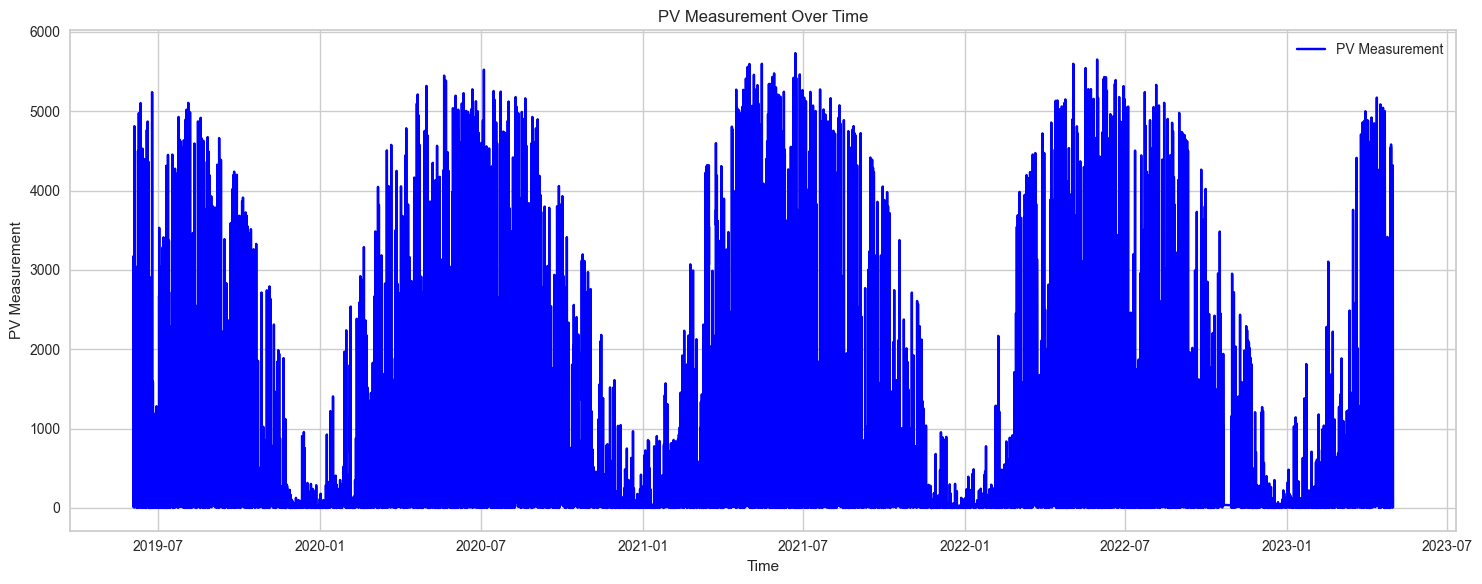

Index(['time', 'pv_measurement'], dtype='object')
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
14:10:34.437: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
14:10:34.442: AutoML: XGBoost is not available; skipping it.
14:10:34.448: _train param, Dropping bad and constant columns: [snow_drift:idx]
14:10:35.164: _train param, Dropping bad and constant columns: [snow_drift:idx]

███
14:10:44.114: _train param, Dropping bad and constant columns: [snow_drift:idx]

██████
14:11:42.553: _train param, Dropping bad and constant columns: [snow_drift:idx]


14:11:49.399: _train param, Dropping bad and constant columns: [snow_dri

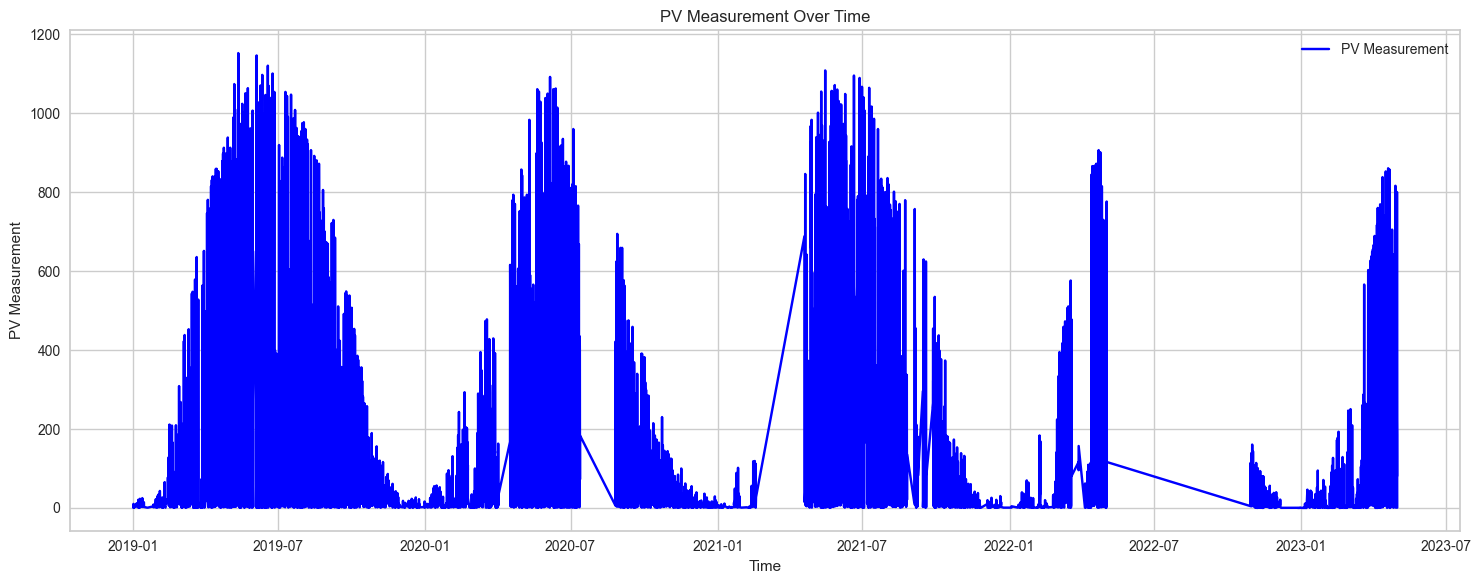

Index(['time', 'pv_measurement'], dtype='object')
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
14:29:03.994: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
14:29:03.996: AutoML: XGBoost is not available; skipping it.
14:29:04.23: _train param, Dropping bad and constant columns: [snow_drift:idx]
14:29:04.725: _train param, Dropping bad and constant columns: [snow_drift:idx]

██
14:29:11.970: _train param, Dropping bad and constant columns: [snow_drift:idx]

███████
14:29:50.693: _train param, Dropping bad and constant columns: [snow_drift:idx]
14:29:55.166: _train param, Dropping bad and constant columns: [snow_drift:

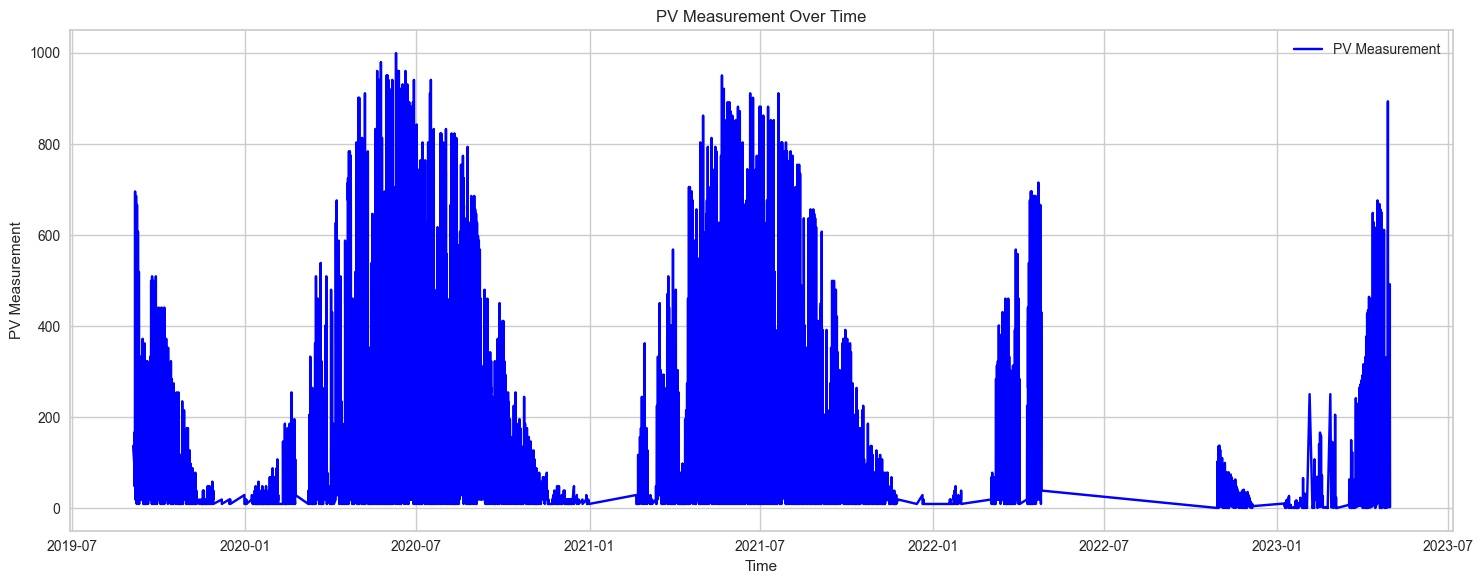

Index(['time', 'pv_measurement'], dtype='object')
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
14:34:02.696: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
14:34:02.696: AutoML: XGBoost is not available; skipping it.
14:34:02.698: _train param, Dropping bad and constant columns: [snow_drift:idx]
14:34:03.125: _train param, Dropping bad and constant columns: [snow_drift:idx]

████████████████████████
14:34:07.582: _train param, Dropping bad and constant columns: [snow_drift:idx]

█
14:36:23.564: _train param, Dropping bad and constant columns: [snow_drift:idx]
14:36:27.694: _train param, Dropping bad and constant colu

In [112]:
#H2o
import h2o
h2o.init()

all_predictions_h2o = []
# H2o model
for loc in locations:
    
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Calling preprocessing
    X_train_h20, X_test_h20, is_day_feature_h20, targets_h20 = preprocessing_h2o(train, X_train_observed, X_train_estimated, X_test_estimated)
    print(targets_h20.columns)
    # Dropping some winter months
    X_train_h20 = X_train_h20[X_train_h20['date_forecast'].dt.month.isin([2,3,4, 5, 6, 7, 8, 9,10])]
    targets_h20 = targets_h20[targets_h20['time'].dt.month.isin([2,3,4, 5, 6, 7, 8, 9,10])]
    
    # Dropping date feature
    X_train_h20 = X_train_h20.drop(columns=['date_forecast'])
    targets_h20 = targets_h20.drop(columns=['time'])

    # Split the training data into training and validation sets
    X_train_h2o, X_val_h2o, y_train_h2o, y_val_h2o = train_test_split(X_train_h20, targets_h20, test_size=0.2, random_state=42)

    # Kombiner X og y for treningsdata
    train_h2o = pd.concat([X_train_h2o, y_train_h2o], axis=1)

    # Kombiner X og y for valideringsdata
    val_h2o = pd.concat([X_val_h2o, y_val_h2o], axis=1)

    # Konverter til H2OFrames
    hf_train = h2o.H2OFrame(pd.DataFrame(train_h2o))
    hf_valid = h2o.H2OFrame(pd.DataFrame(val_h2o))


    from h2o.automl import H2OAutoML

    aml_a = H2OAutoML(max_models=20, seed=42, exclude_algos=["DeepLearning"])
    aml_a.train(y='pv_measurement', training_frame=hf_train, validation_frame=hf_valid)

    best_model = aml_a.leader
    lb_a = aml_a.leaderboard
    print(lb_a.head(rows=lb_a.nrows))

    h20_prediction = best_model.predict(h2o.H2OFrame(pd.DataFrame(X_test_h20)))

    # Convert H2O predictions to pandas DataFrame
    h20_prediction = h20_prediction.as_data_frame()
    #final_predictions_rf = predictions_rf['prediction_label']
    
    # Multiply final predictions with the 'is_day:idx' values
    adjusted_final_predictions_h2o = h20_prediction['predict'] * is_day_feature_h20['is_day:idx']
    
    # Cliping values under zero to zero
    adjusted_final_predictions_h2o = np.clip(adjusted_final_predictions_h2o, 0, None)
    
    # Store predictions
    all_predictions_h2o.append([adjusted_final_predictions_h2o]) 
     
     
all_predictions_h2o = np.array(all_predictions_h2o)


In [ ]:
print(h20_prediction)

       predict
0    -0.022870
1    -0.394238
2     3.438564
3     6.553615
4    12.477888
..         ...
715  70.038045
716  37.521111
717  17.985181
718  12.603548
719  11.534741

[720 rows x 1 columns]


In [ ]:
'''# Catboost OG for all loc, and some other things that didnt work
for loc in locations:

    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
   
    
    
    # Preprocess data
    
    X_train_cat_2, X_test_cat_2, is_day_feature2, targets_cat_2 = preprocessing_cat_2(train, X_train_observed, X_train_estimated, X_test_estimated)
    all_X_train_cat = pd.concat([all_X_train_cat, X_train_cat_2], ignore_index=True)
    all_X_test_cat = pd.concat([all_X_test_cat, X_test_cat_2], ignore_index=True)
    all_is_day_feature1 = pd.concat([all_is_day_feature1, is_day_feature2], ignore_index=True)
    all_targets_cat = pd.concat([all_targets_cat, targets_cat_2], ignore_index=True)

    stacked_model = process_location_stacked(X_train, X_train_cat, targets_cat_2, targets_cat, loc)
    pred_stacked = predict_model(stack_models, data = X_test)
    fin_pred_stacked = pred_stacked['prediction_label']
    ajust = fin_pred_stacked* is_day_feature['is_day:idx']
    ajust = np.clip(ajust, 0, None)
    all_pred_stacked.append([ajust])

    # time series spilt to spilt data for cat model
    

    def split_based_on_time(X, y, n_splits=6):
        
        ts = TimeSeriesSplit(n_splits=n_splits)
        for index, t_index in ts.split(X):
            pass  # Only using last spilt
        
        X_train, X_test = X.iloc[index], X.iloc[t_index]
        y_train, y_test = y.iloc[index], y.iloc[t_index]
        return X_train, X_test, y_train, y_test
    
    cat_models = train_multiple_catboost_models(X_train_cat, targets_cat['pv_measurement'], cat_features, seeds)'''

    # Ensemble the predictions
    #predictions_cat = ensemble_catboost_predictions(cat_models, X_test_cat)
    '''A = np.column_stack((all_predictions_lGBM[0],all_predictions_rf[0],all_predictions_lasso[0],all_predictions_cat[0]))
    meta_learner = LinearRegression().fit(stacked_predictions, true_values)
    model = sm.GLM(true_values, X, family=sm.families.Gaussian()).fit()'''

    '''# Prepare dataframe for visualization
    num_predictions = len(all_pred)
    timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

    df = pd.DataFrame({
            'time': timestamps,
            'prediction': all_pred['prediction_label'],
            'location': loc
        })

    final_df_list.append(df)
'''
#Traing a cat model with all loc input

'''all_X_train_cat = all_X_train_cat.drop(columns=['date_forecast'])
final_model_cat_2 = process_location_cat_2(all_X_train_cat, all_targets_cat)
predictions_cat_2 = predict_model(final_model_cat_2, data=all_X_test_cat)
final_predictions_cat_2 = predictions_cat_2['prediction_label']
adjusted_final_predictions_cat_2 = final_predictions_cat_2 * all_is_day_feature1['is_day:idx']
adjusted_final_predictions_cat_2 = np.clip(adjusted_final_predictions_cat_2, 0, None)
all_predictions_cat_2 = adjusted_final_predictions_cat_2'''


'''
# Concatenate all the individual data frames and prepare for plotting
final_df = pd.concat(final_df_list, ignore_index=True)
final_df['time'] = pd.to_datetime(final_df['time'])
final_df.sort_values('time', inplace=True)

# Visualization
for loc in locations:
    # Filter data for each location
    temp_df = final_df[final_df['location'] == loc]
    
    plt.figure(figsize=(12, 6))  # Create a new figure for each location
    plt.plot(temp_df['time'], temp_df['prediction'], label=f'Location {loc}')
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    plt.show()

# If you need to save the final dataframe without 'time' and 'location' columns, you can do so before plotting
final_df_save = final_df.copy()
save = final_df.copy()
final_df_save = final_df_save.drop(columns=['time', 'location'])'''

# Combining Model Predictions

In [155]:
all_predictions_lGBM_e = np.array(all_predictions_lGBM_e).flatten()
all_predictions_rf = np.array(all_predictions_rf).flatten()
all_predictions_cat = np.array(all_predictions_cat).flatten()
all_predictions_cat_2 = np.array(all_predictions_cat_2).flatten()
all_predictions_cat_3 = np.array(all_predictions_cat_3).flatten()
all_predictions_h2o = np.array(all_predictions_h2o).flatten()
#all_pred_stacked = np.array(all_pred_stacked).flatten()
all_pred = 0.15*all_predictions_cat+0.25 * all_predictions_lGBM_e+ 0.15* all_predictions_cat_2+0.2*all_predictions_cat_3+ 0.05*all_predictions_rf+ 0.2*all_predictions_h2o#+ 0.45*all_predictions_lGBM  +  0.1*all_predictions_cat + 0.25*all_predictions_lasso + 0.1*all_predictions_rf
all_pred[all_pred < 4] = 0
print(all_pred.shape)

(2160,)


In [145]:
# Split predictions into locations
location_a_pred = all_pred[:720]
location_b_pred = all_pred[720:1440]
location_c_pred = all_pred[1440:]

# Convert NumPy arrays to pandas DataFrames
location_a_pred = pd.DataFrame(location_a_pred, columns=['predictions'])
location_b_pred = pd.DataFrame(location_b_pred, columns=['predictions'])
location_c_pred = pd.DataFrame(location_c_pred, columns=['predictions'])

loc_a = 'A'
loc_b = 'B'
loc_c = 'C'
merged_data = merged_data[merged_data['pv_measurement'] != 0]
train_a = pd.read_parquet(f'{loc_a}/train_targets.parquet').fillna(0)
train_b = pd.read_parquet(f'{loc_b}/train_targets.parquet').fillna(0)
train_c = pd.read_parquet(f'{loc_c}/train_targets.parquet').fillna(0)

train_a = train_a[train_a['pv_measurement'] != 0]
train_b = train_b[train_b['pv_measurement'] != 0]
train_c = train_c[train_c['pv_measurement'] != 0]

def remove_constant_blocks(data):
    # Calculate the difference
    data['diff'] = data['pv_measurement'].diff().fillna(0)

    # Create an indicator where diff is zero
    data['constant'] = (data['diff'] == 0).astype(int)

    # Identify change-points and calculate block sizes
    data['block'] = (data['constant'].diff() != 0).astype(int).cumsum()
    block_sizes = data.groupby('block')['constant'].sum()

    # Identify and remove constant blocks
    constant_blocks = block_sizes[block_sizes > 2].index
    filtered_data = data[~data['block'].isin(constant_blocks)]

    # Drop temporary features
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])

    return filtered_data

# Function to align and remove constant blocks
def process_data(train_a, train_b):
    train_a_processed = remove_constant_blocks(train_a)
    train_b_processed = remove_constant_blocks(train_b)

    # Align datasets
    train_a_aligned, train_b_aligned = train_a_processed.align(train_b_processed, join='inner', axis=0)
    train_a_aligned.dropna(inplace=True)
    train_b_aligned.dropna(inplace=True)

    return train_a_aligned, train_b_aligned

# Process and align datasets for each pair
X_train_ab, y_train_ab = process_data(train_a, train_b)
X_train_ac, y_train_ac = process_data(train_a, train_c)
X_train_ba, y_train_ba = process_data(train_b, train_a)
print(y_train_ab)
y_train_ab = y_train_ab['pv_measurement']
y_train_ac = y_train_ac['pv_measurement']
y_train_ba = y_train_ba['pv_measurement']

X_train_ab = X_train_ab.drop(columns=['time'])
X_train_ac = X_train_ac.drop(columns=['time'])
X_train_ba = X_train_ba.drop(columns=['time'])
# Split into training and validation sets for each pair
X_train_ab, X_valid_ab, y_train_ab, y_valid_ab = train_test_split(X_train_ab, y_train_ab, test_size=0.2, random_state=42)
X_train_ac, X_valid_ac, y_train_ac, y_valid_ac = train_test_split(X_train_ac, y_train_ac, test_size=0.2, random_state=42)
X_train_ba, X_valid_ba, y_train_ba, y_valid_ba = train_test_split(X_train_ba, y_train_ba, test_size=0.2, random_state=42)


print(X_train_ab.dtypes)
# Initialize and train CatBoost models
model_ab = CatBoostRegressor(
    verbose=100, 
    learning_rate=0.03,
    depth=10,
    l2_leaf_reg=5,
    random_state=42, 
    n_estimators=20000, 
    loss_function='MAE', 
    early_stopping_rounds=100,
)
model_ab.fit(X_train_ab, y_train_ab, eval_set=(X_valid_ab, y_valid_ab), verbose=True)

model_ac = CatBoostRegressor(
    verbose=100, 
    learning_rate=0.03,
    depth=10,
    l2_leaf_reg=5,
    random_state=42, 
    n_estimators=20000, 
    loss_function='MAE', 
    early_stopping_rounds=100,
)
model_ac.fit(X_train_ac, y_train_ac, eval_set=(X_valid_ac, y_valid_ac), verbose=True)

model_ba = CatBoostRegressor(
    verbose=100, 
    learning_rate=0.03,
    depth=10,
    l2_leaf_reg=5,
    random_state=42, 
    n_estimators=20000, 
    loss_function='MAE', 
    early_stopping_rounds=100,
)
model_ba.fit(X_train_ba, y_train_ba, eval_set=(X_valid_ba, y_valid_ba), verbose=True)

# Make predictions
predictions_ab = model_ab.predict(location_a_pred)
predictions_ac = model_ac.predict(location_a_pred)
predictions_ba = model_ba.predict(location_b_pred)

# Combine predictions back with the original data (adjust weights as needed)
final_predictions_a = 0.9 * location_a_pred + 0.1 * predictions_ba
final_predictions_b = 0.9 * location_b_pred + 0.1 * predictions_ab
final_predictions_c = 0.9 * location_c_pred + 0.1 * predictions_ac
print(len(final_predictions_a))
print(len(final_predictions_b))
print(len(final_predictions_c))

# Convert NumPy arrays to pandas Series (or DataFrames)
final_predictions_a = pd.Series(final_predictions_a)
final_predictions_b = pd.Series(final_predictions_b)
final_predictions_c = pd.Series(final_predictions_c)

# Combine all predictions back into a single series
final_all_predictions = pd.concat([final_predictions_a, final_predictions_b, final_predictions_c])

                     time  pv_measurement
11    2019-01-01 10:00:00        0.862500
12    2019-01-01 11:00:00       10.350000
13    2019-01-01 12:00:00        5.175000
14    2019-01-01 13:00:00        0.862500
35    2019-01-02 10:00:00        3.450000
...                   ...             ...
32827 2023-04-30 03:00:00        2.791160
32828 2023-04-30 04:00:00       37.166395
32829 2023-04-30 05:00:00       65.568082
32842 2023-04-30 18:00:00       45.263035
32843 2023-04-30 19:00:00        0.828587

[5912 rows x 2 columns]
pv_measurement    float64
dtype: object
0:	learn: 170.8086626	test: 176.2574176	best: 176.2574176 (0)	total: 11ms	remaining: 3m 39s
1:	learn: 170.7540717	test: 176.2250398	best: 176.2250398 (1)	total: 20.9ms	remaining: 3m 29s
2:	learn: 170.7067827	test: 176.2013451	best: 176.2013451 (2)	total: 34.4ms	remaining: 3m 49s
3:	learn: 170.6583935	test: 176.1752585	best: 176.1752585 (3)	total: 46ms	remaining: 3m 50s
4:	learn: 170.6131778	test: 176.1541336	best: 176.1541336 (

CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 0 should be feature with name pv_measurement (found predictions).

In [134]:
print(len(final_all_predictions))
print(all_pred)
final_all_predictions[final_all_predictions < 6] = 0
final_all_predictions = np.array(final_all_predictions).flatten()

2160
[0.       0.       0.       ... 6.145575 0.       0.      ]


#### Saving the final predictions to CSV

In [156]:
'''sample_submission = pd.read_csv('sample_submission.csv')
sample_submission
sample_submission = sample_submission[['id']].merge(final_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)'''

final_predictions = all_pred

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('final_predictions.csv', index=False)

In [ ]:
# Function to get the next run_id
def get_next_run_id():
    
    counter_file = 'run_counter.txt'

    if not os.path.exists(counter_file):
        with open(counter_file, 'w') as file:
            file.write('1')
            return 'run1'

    with open(counter_file, 'r') as file:
        current_count = int(file.read())

    new_run_id = f"run{current_count}"

    with open(counter_file, 'w') as file:
        file.write(str(current_count + 1))

    return new_run_id

# Get the next run_id
run_id = get_next_run_id()

# Save the predictions to a CSV, including the run_id in the filename
save.to_csv(f'predictions_{run_id}.csv')

NameError: name 'save' is not defined

#### Plotting and Comparing Time-Series Predictions for Multiple Locations

In [ ]:
# Plotting and Comparing Time-Series Predictions for Multiple Locations 

# Directory where the prediction files are saved
pred_dir = os.getcwd()

# Compile a regular expression pattern to match prediction files with a specific naming pattern
regex = re.compile(r'predictions_run\d+.*\.csv$')

# List all prediction CSV files in the directory that match the pattern
pred_files = [f for f in os.listdir(pred_dir) if regex.match(f)]

# Create a dictionary of dataframes, each containing data from the prediction files
dfs = {}
for file in pred_files:
    key = file.replace('.csv', '')  
    dfs[key] = pd.read_csv(os.path.join(pred_dir, file))

# Assuming all prediction files have the same locations
locations = dfs[list(dfs.keys())[0]]['location'].unique()

# Define a color palette
colors = plt.cm.tab10.colors 

# Start plotting comparison graphs for each unique location
for loc in locations:
    plt.figure(figsize=(12, 6))
    color_idx = 0  # Create a cycle iterator
    
    # Plot each dataframe on the same plot
    for run_id, df in dfs.items():
        temp_df = df[df['location'] == loc]
        plt.plot(temp_df['time'], temp_df['prediction'], label=f'{run_id} for Location {loc}', color=colors[color_idx])
        color_idx = (color_idx + 1) % len(colors)
        
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    
    # Save the comparison figure
    plt.savefig(f'Location_{loc}_comparisons.png')
    plt.close()
